In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import torchvision.transforms as transforms
import glob
import torchvision
import time
import random
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [ ]:
!nvidia-smi

Sun Jan  7 06:15:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              44W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import RandomChoice

ROOT_DIR_TRAIN = "/content/drive/MyDrive/PlantDoc-Dataset/train"
ROOT_DIR_TEST = "/content/drive/MyDrive/PlantDoc-Dataset/test"

# Transforms for training
train_transform =  transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

# Transforms for validation/testing
test_valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Prepare the Dataset
dataset_train = datasets.ImageFolder(root=ROOT_DIR_TRAIN, transform=train_transform)
dataset_valid = datasets.ImageFolder(root=ROOT_DIR_TRAIN, transform=test_valid_transform)
test_dataset = datasets.ImageFolder(root=ROOT_DIR_TEST, transform=test_valid_transform)

train_size = int(0.80 * len(dataset_train))
valid_size = len(dataset_train) - train_size

# Radomize the data indices.
indices = torch.randperm(len(dataset_train)).tolist()
# Training and validation sets.
train_dataset = Subset(dataset_train, indices[:-valid_size])
valid_dataset = Subset(dataset_valid, indices[-valid_size:])

# Prepare the Data Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

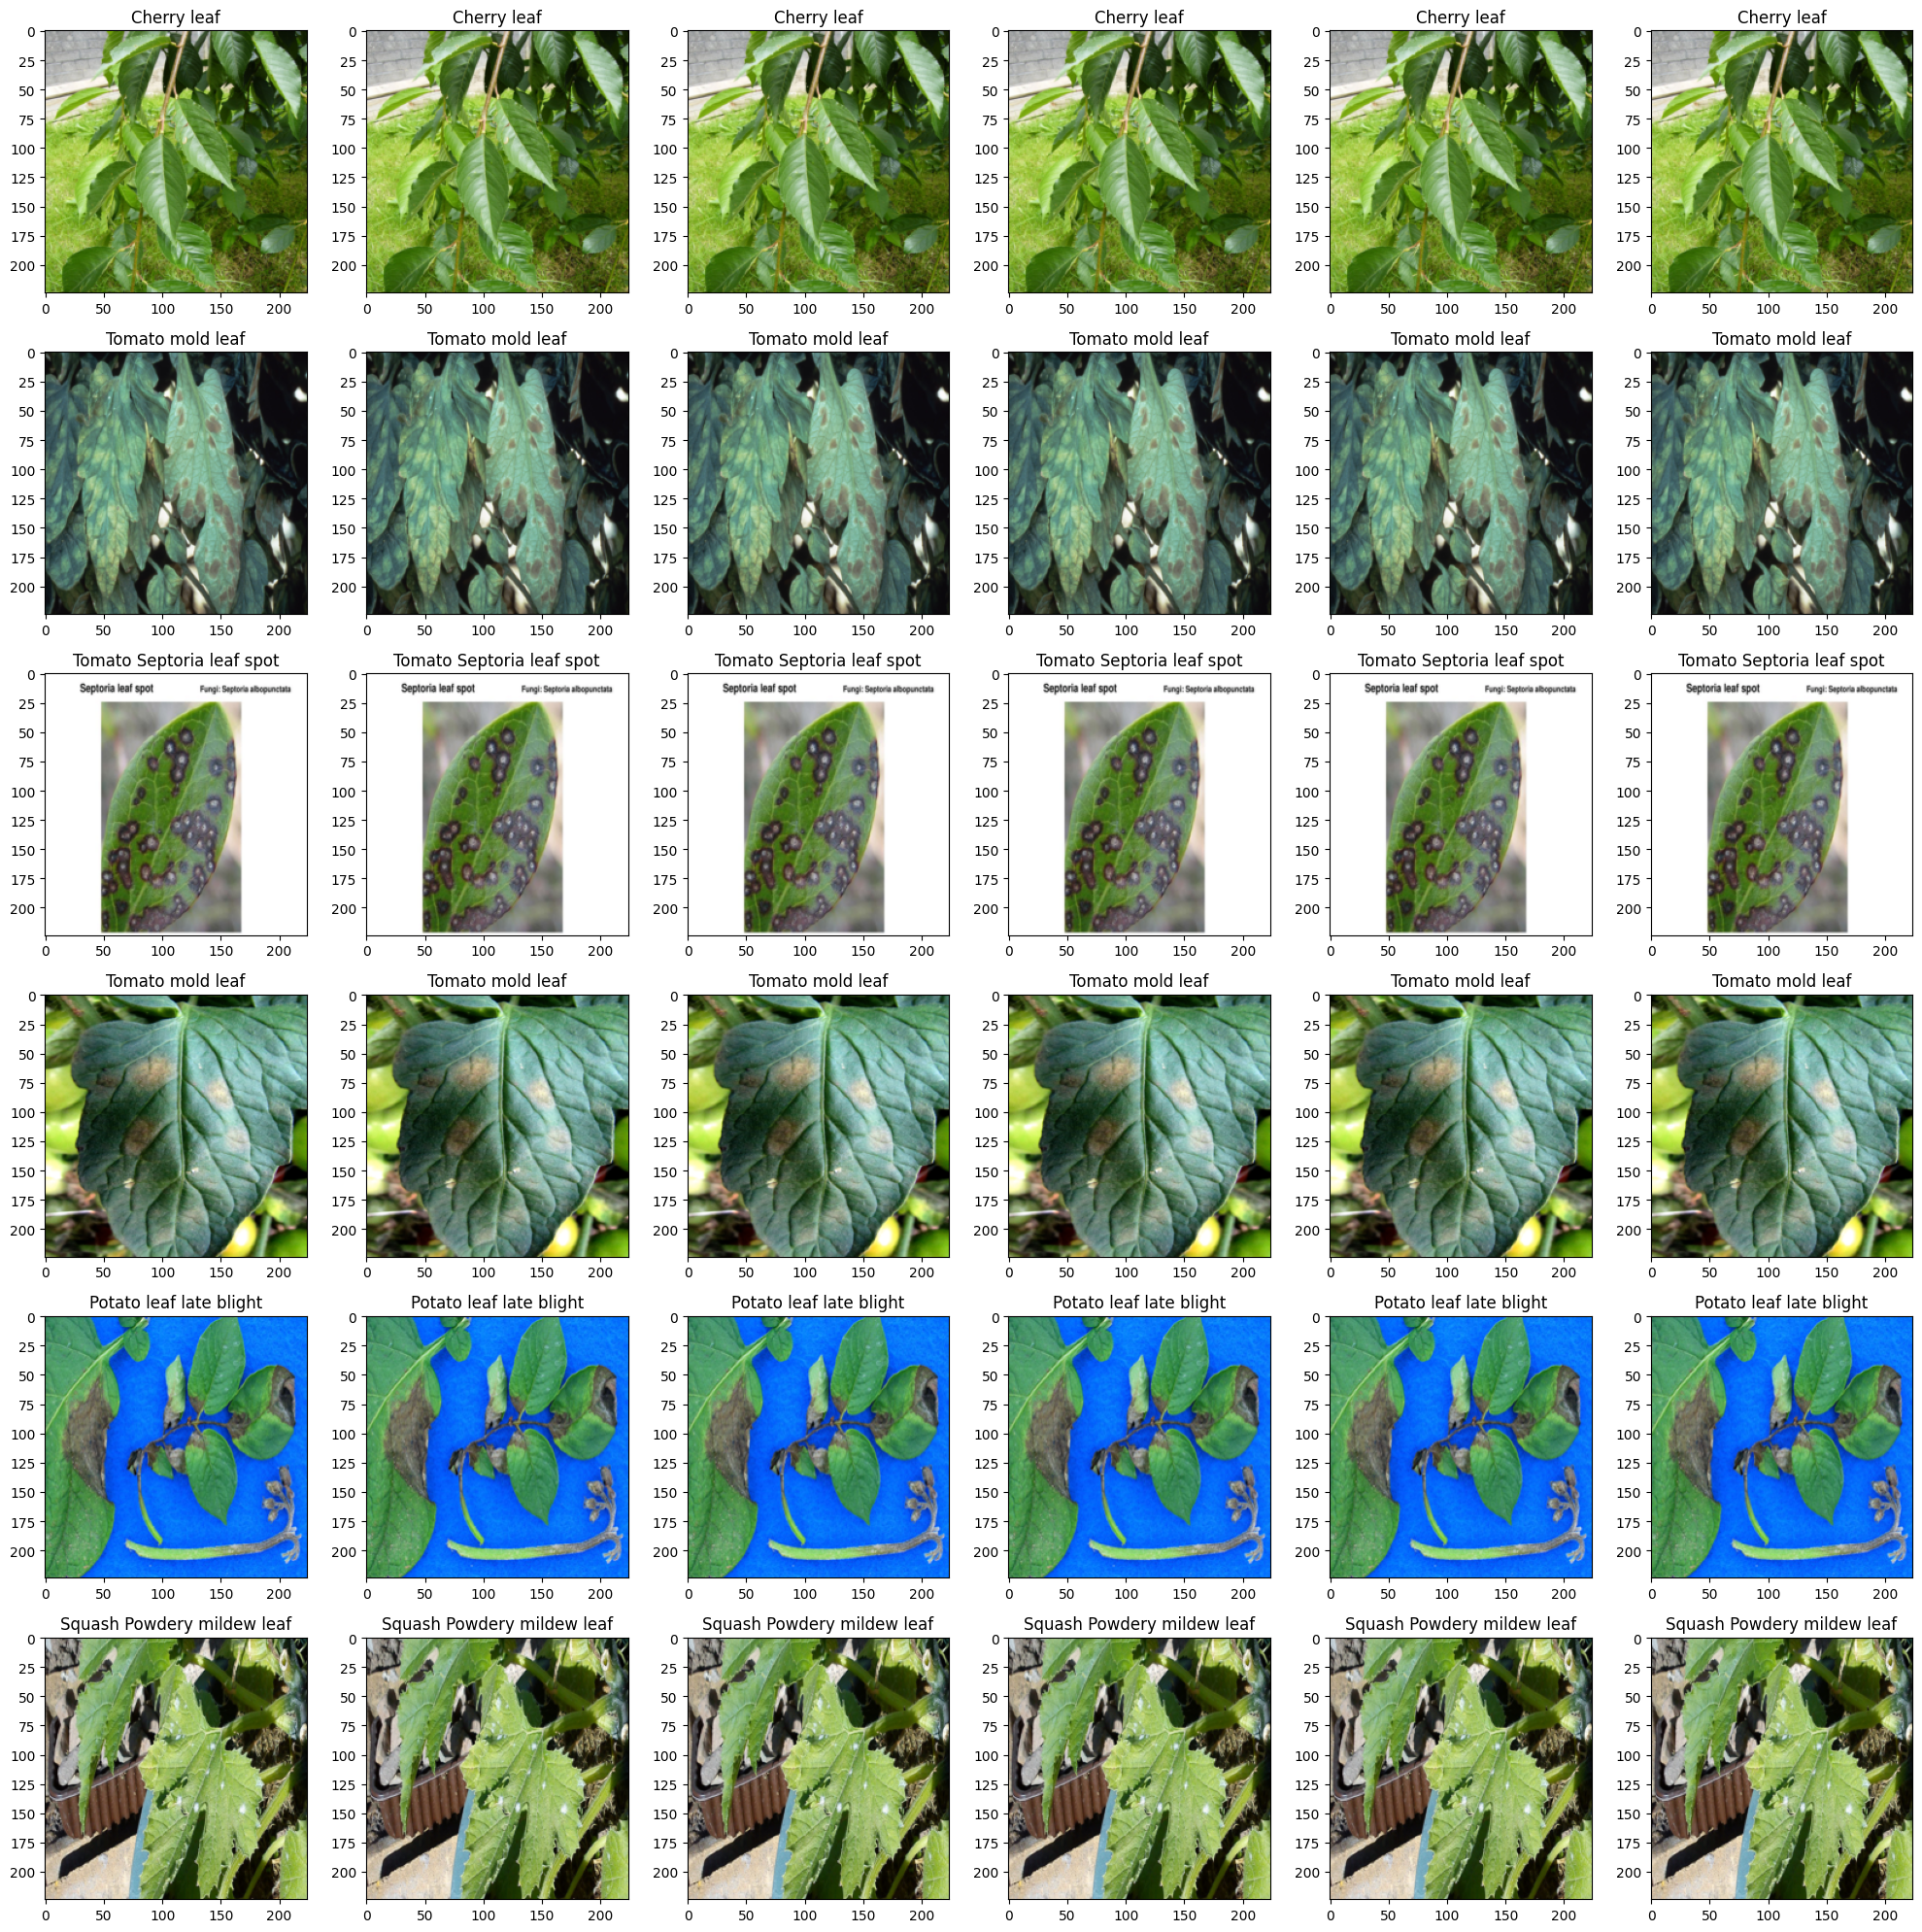

In [ ]:
def show_dataset(dataset_train, n=6):
    fig, axs = plt.subplots(n, n, figsize=(20, 20))

    for row in range(n):
        idx = np.random.randint(len(dataset_train))  # select the same index for each row
        for col in range(n):
            images, labels = dataset_train[idx]
            images = images.permute(1, 2, 0)  # CxHxW -> HxWxC
            images = images * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])  # denormalize
            images = (images * 255).byte().numpy()  # convert to uint8 numpy array
            axs[row, col].imshow(images)
            axs[row, col].set_title(dataset_train.classes[labels])
            axs[row, col].axis()

    plt.tight_layout()
    plt.show()

# Show Dataset
show_dataset(dataset_train)

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.2 MB/s eta 0:00:00


In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from torchinfo import summary
import timm

# Load a pre-trained EVA-02 model
model = timm.create_model('eva02_large_patch14_224.mim_m38m', pretrained=True)

# Set the number of classes to match your dataset
num_classes = 27

# Modify the fully connected layer to match the number of classes
model.head = nn.Linear(1024, num_classes)

# Set the device (CPU or GPU)
model.to(device)

# Display the model summary
summary(model, input_size=(1, 3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

Layer (type:depth-idx)                   Output Shape              Param #
Eva                                      [1, 27]                   264,192
├─PatchEmbed: 1-1                        [1, 256, 1024]            --
│    └─Conv2d: 2-1                       [1, 1024, 16, 16]         603,136
│    └─Identity: 2-2                     [1, 256, 1024]            --
├─Dropout: 1-2                           [1, 257, 1024]            --
├─ModuleList: 1-3                        --                        --
│    └─EvaBlock: 2-3                     [1, 257, 1024]            --
│    │    └─LayerNorm: 3-1               [1, 257, 1024]            2,048
│    │    └─EvaAttention: 3-2            [1, 257, 1024]            4,197,376
│    │    └─Identity: 3-3                [1, 257, 1024]            --
│    │    └─LayerNorm: 3-4               [1, 257, 1024]            2,048
│    │    └─SwiGLU: 3-5                  [1, 257, 1024]            8,398,504
│    │    └─Identity: 3-6                [1, 257, 1024]

In [ ]:
print(model)

Eva(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (rope): RotaryEmbeddingCat()
  (blocks): ModuleList(
    (0-23): 24 x EvaBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): EvaAttention(
        (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
        (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLU(
        (fc1_g): Linear(in_features=1024, out_features=2730, bias=True)
        (fc1_x): Linear(in

In [ ]:
# ฟังก์ชันสำหรับบันทึกโมเดลและผลลัพธ์การฝึกอบรม
def save_model(epoch, fold, model, optimizer, training_results, fold_results, path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_results': training_results,
        'fold_results': fold_results,
    }, f"{path}_fold_{fold}.pth")

In [ ]:
# ฟังก์ชันสำหรับโหลดโมเดลและผลลัพธ์การฝึกอบรม
def load_model(fold, model, optimizer, path):
    specific_path = f"{path}_fold_{fold}.pth"
    if os.path.exists(specific_path):
        checkpoint = torch.load(specific_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        training_results = checkpoint.get('training_results', {
            'train_losses': [], 'valid_losses': [], 'test_losses': [],
            'train_accs': [], 'valid_accs': [], 'test_accs': []
        })
        fold_results = checkpoint.get('fold_results', {
            'fold_train_losses': [], 'fold_valid_losses': [], 'fold_test_losses': [],
            'fold_train_accs': [], 'fold_valid_accs': [], 'fold_test_accs': []
        })
        return checkpoint['epoch'], training_results, fold_results
    return 0, {
        'train_losses': [], 'valid_losses': [], 'test_losses': [],
        'train_accs': [], 'valid_accs': [], 'test_accs': []
    }, {
        'fold_train_losses': [], 'fold_valid_losses': [], 'fold_test_losses': [],
        'fold_train_accs': [], 'fold_valid_accs': [], 'fold_test_accs': []
    }

In [ ]:
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Subset

def train_model(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)

    return epoch_loss, epoch_acc

def validate_model(model, criterion, valid_loader, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(valid_loader.dataset)
        epoch_acc = running_corrects.double() / len(valid_loader.dataset)

    return epoch_loss, epoch_acc

In [ ]:
def test_model(model, criterion, test_loader, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = running_corrects.double() / len(test_loader.dataset)

    return epoch_loss, epoch_acc

In [ ]:
# Set the number of folds
num_folds = 5
num_epochs = 50
checkpoint_path = '/content/drive/MyDrive/PlantDoc-Dataset/EVA-02_Model_checkpoint.pth'

# Set the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Load and prepare the model
model.to(device)

# Prepare the data
X = np.arange(len(dataset_train))
y = np.array([label for _, label in dataset_valid.imgs])

# Set up the StratifiedKFold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize lists to store fold results
fold_train_losses = []
fold_valid_losses = []
fold_test_losses = []
fold_train_accs = []
fold_valid_accs = []
fold_test_accs = []

for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{num_folds}")

    # โหลดโมเดลสำหรับ fold นี้
    start_epoch, training_results, fold_results = load_model(fold, model, optimizer, checkpoint_path)

    # ตรวจสอบว่า fold นี้ฝึกอบรมครบ 50 epochs หรือยัง
    if start_epoch >= num_epochs:
        continue

    if training_results:
        # แสดงผลลัพธ์การฝึกอบรมทั้งหมดจาก checkpoint
        for epoch in range(start_epoch):
            print(f"Epoch {epoch + 1}/{num_epochs}: "
                  f"Train Loss: {training_results['train_losses'][epoch]:.4f} "
                  f"Train Accuracy: {training_results['train_accs'][epoch] * 100:.4f} "
                  f"Valid Loss: {training_results['valid_losses'][epoch]:.4f} "
                  f"Valid Accuracy: {training_results['valid_accs'][epoch] * 100:.4f} "
                  f"Test Loss: {training_results['test_losses'][epoch]:.4f} "
                  f"Test Accuracy: {training_results['test_accs'][epoch] * 100:.4f}")

    # Create data loaders for the current fold
    train_data = Subset(dataset_train, train_index)
    valid_data = Subset(dataset_valid, valid_index)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Train and validate the model
    epoch_train_losses = []
    epoch_valid_losses = []
    epoch_test_losses = []
    epoch_train_accs = []
    epoch_valid_accs = []
    epoch_test_accs = []

    for epoch in range(start_epoch, num_epochs):
        train_loss, train_acc = train_model(model, criterion, optimizer, train_loader, device)
        valid_loss, valid_acc = validate_model(model, criterion, valid_loader, device)
        test_loss, test_acc = test_model(model, criterion, test_loader, device)

        epoch_train_losses.append(train_loss)
        epoch_valid_losses.append(valid_loss)
        epoch_test_losses.append(test_loss)
        epoch_train_accs.append(train_acc)
        epoch_valid_accs.append(valid_acc)
        epoch_test_accs.append(test_acc)

        # เพิ่มผลลัพธ์การฝึกอบรมใน epoch นี้เข้าไปใน training_results
        training_results['train_losses'].append(train_loss)
        training_results['valid_losses'].append(valid_loss)
        training_results['test_losses'].append(test_loss)
        training_results['train_accs'].append(train_acc)
        training_results['valid_accs'].append(valid_acc)
        training_results['test_accs'].append(test_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f} Train Accuracy: {train_acc * 100:.4f} "
              f"Valid Loss: {valid_loss:.4f} Valid Accuracy: {valid_acc * 100:.4f} "
              f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc * 100:.4f}")

    fold_train_losses.append(epoch_train_losses)
    fold_valid_losses.append(epoch_valid_losses)
    fold_test_losses.append(epoch_test_losses)
    fold_train_accs.append(epoch_train_accs)
    fold_valid_accs.append(epoch_valid_accs)
    fold_test_accs.append(epoch_test_accs)

    fold_results['fold_train_losses'].append(epoch_train_losses)
    fold_results['fold_valid_losses'].append(epoch_valid_losses)
    fold_results['fold_test_losses'].append(epoch_test_losses)
    fold_results['fold_train_accs'].append(epoch_train_accs)
    fold_results['fold_valid_accs'].append(epoch_valid_accs)
    fold_results['fold_test_accs'].append(epoch_test_accs)

    print("Finished Fold")
    print("=" * 50)

    save_model(epoch, fold, model, optimizer, training_results, fold_results, checkpoint_path)

Fold 1/5
Epoch 1/50: Train Loss: 1.6529 Train Accuracy: 50.8639 Valid Loss: 0.9678 Valid Accuracy: 69.3966 Test Loss: 0.9946 Test Accuracy: 66.1017
Epoch 2/50: Train Loss: 0.6781 Train Accuracy: 76.7279 Valid Loss: 0.7729 Valid Accuracy: 73.0603 Test Loss: 0.8331 Test Accuracy: 71.1864
Epoch 3/50: Train Loss: 0.3691 Train Accuracy: 86.7711 Valid Loss: 0.7921 Valid Accuracy: 75.0000 Test Loss: 0.9719 Test Accuracy: 68.6441
Epoch 4/50: Train Loss: 0.2328 Train Accuracy: 91.9006 Valid Loss: 0.7804 Valid Accuracy: 75.4310 Test Loss: 0.7299 Test Accuracy: 75.8475
Epoch 5/50: Train Loss: 0.1228 Train Accuracy: 96.3283 Valid Loss: 0.7997 Valid Accuracy: 73.7069 Test Loss: 0.7954 Test Accuracy: 74.5763
Epoch 6/50: Train Loss: 0.0729 Train Accuracy: 98.4341 Valid Loss: 0.8994 Valid Accuracy: 76.5086 Test Loss: 0.9181 Test Accuracy: 75.4237
Epoch 7/50: Train Loss: 0.0798 Train Accuracy: 98.0022 Valid Loss: 0.8477 Valid Accuracy: 76.2931 Test Loss: 0.9620 Test Accuracy: 71.6102
Epoch 8/50: Train 

In [ ]:
# Evaluate the trained model on the training and validation sets for each fold.
avg_train_acc_k_folds = []
avg_val_acc_k_folds = []

def evaluate_accuracy(history, index):
    history_cpu = [item.cpu() for item in history]
    return sum(history_cpu) / len(history_cpu)

for i in range(num_folds):
    train_accuracy = evaluate_accuracy(fold_train_accs[i], 2)
    valid_accuracy = evaluate_accuracy(fold_valid_accs[i], 3)
    print(f'Fold {i + 1}/{num_folds}:')
    print(f'\tTraining Accuracy: {train_accuracy * 100:.2f}%')
    print(f'\tValidation Accuracy: {valid_accuracy * 100:.2f}%')
    avg_train_acc_k_folds.append(train_accuracy)
    avg_val_acc_k_folds.append(valid_accuracy)

# Compute the average training and validation accuracy over all folds.
overall_train_acc = sum(avg_train_acc_k_folds) / len(avg_train_acc_k_folds)
overall_val_acc = sum(avg_val_acc_k_folds) / len(avg_val_acc_k_folds)

# Calculate the average and standard deviation of the training and validation accuracy over all folds.
avg_train_acc = np.mean(avg_train_acc_k_folds)
std_train_acc = np.std(avg_train_acc_k_folds)
avg_val_acc = np.mean(avg_val_acc_k_folds)
std_val_acc = np.std(avg_val_acc_k_folds)

# Print the average and standard deviation of the training and validation accuracy over all folds.
print(f'\nAverage Training Accuracy over {num_folds}-fold Cross Validation: {avg_train_acc * 100:.2f}% +/- {std_train_acc * 100:.2f}%')
print(f'Average Validation Accuracy over {num_folds}-fold Cross Validation: {avg_val_acc * 100:.2f}% +/- {std_val_acc * 100:.2f}%')

Fold 1/5:
	Training Accuracy: 99.08%
	Validation Accuracy: 78.88%
Fold 2/5:
	Training Accuracy: 99.68%
	Validation Accuracy: 97.84%
Fold 3/5:
	Training Accuracy: 99.46%
	Validation Accuracy: 98.70%
Fold 4/5:
	Training Accuracy: 99.57%
	Validation Accuracy: 99.35%
Fold 5/5:
	Training Accuracy: 99.51%
	Validation Accuracy: 99.14%

Average Training Accuracy over 5-fold Cross Validation: 99.46% +/- 0.20%
Average Validation Accuracy over 5-fold Cross Validation: 94.78% +/- 7.97%


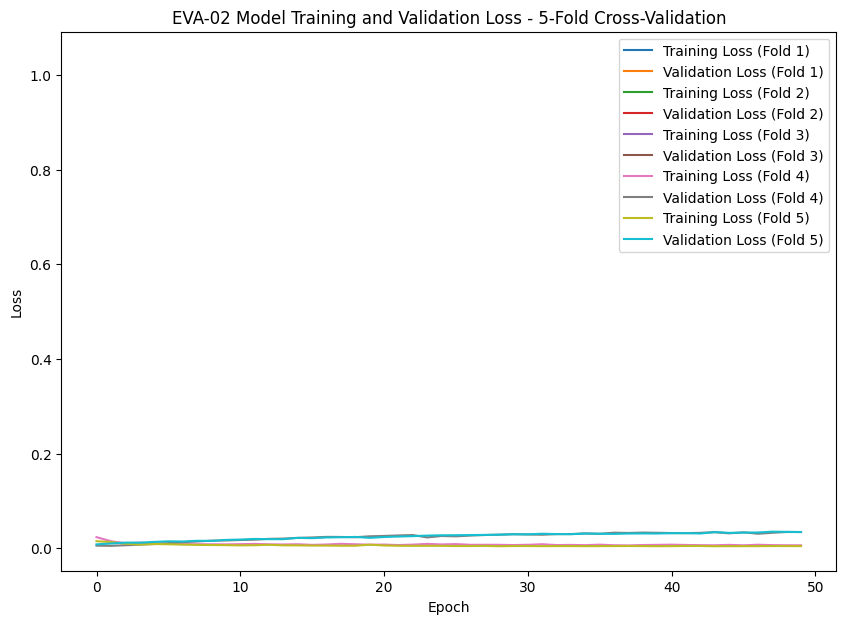

In [ ]:
# Plot the training and validation loss for each epoch
model_name = "EVA-02 Model"
plt.figure(figsize=(10, 7))
for fold in range(num_folds):
    plt.plot(fold_train_losses[fold], label=f'Training Loss (Fold {fold+1})')
    plt.plot(fold_valid_losses[fold], label=f'Validation Loss (Fold {fold+1})')

plt.title(f'{model_name} Training and Validation Loss - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


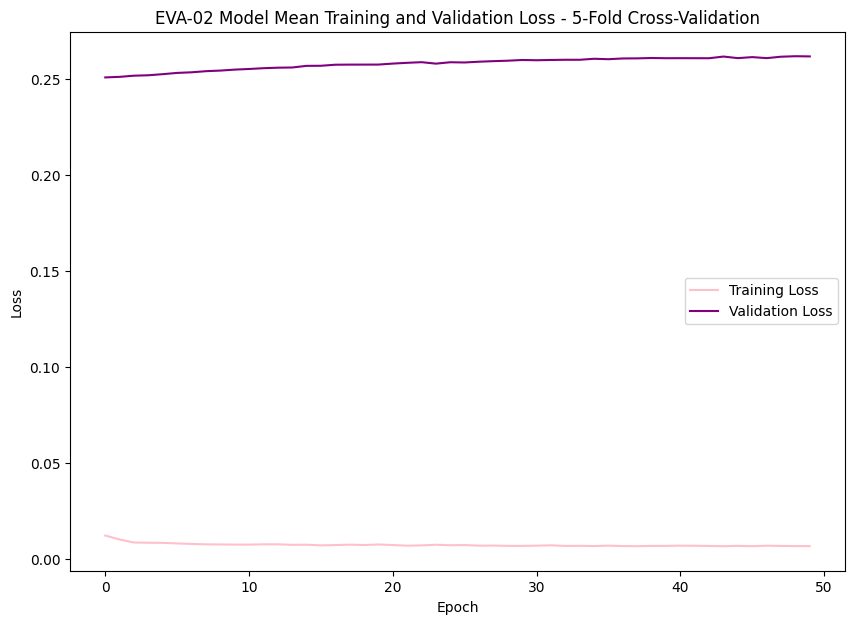

In [ ]:
# Compute mean loss across all folds at each epoch
train_loss_mean = np.mean([np.array(fold_train_losses[i]) for i in range(num_folds)], axis=0)
valid_loss_mean = np.mean([np.array(fold_valid_losses[i]) for i in range(num_folds)], axis=0)

# Plot mean loss history
plt.figure(figsize=(10, 7))
plt.plot(train_loss_mean, label='Training Loss', color='pink')
plt.plot(valid_loss_mean, label='Validation Loss', color='purple')
plt.title(f'{model_name} Mean Training and Validation Loss - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

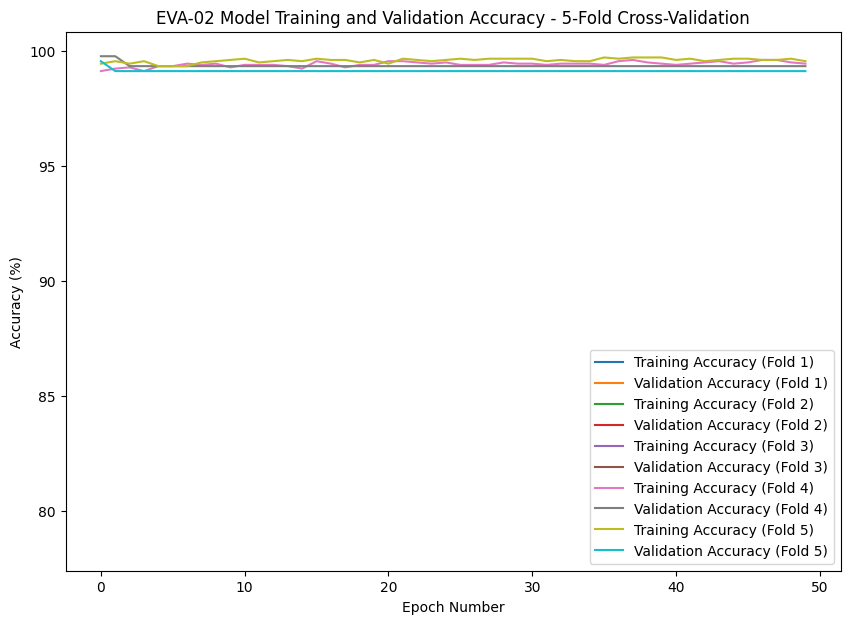

In [ ]:
# Plot the training and validation accuracy for each epoch
plt.figure(figsize=(10, 7))
for fold in range(num_folds):
    plt.plot(np.array([acc.cpu() for acc in fold_train_accs[fold]]) * 100, label=f'Training Accuracy (Fold {fold+1})')
    plt.plot(np.array([acc.cpu() for acc in fold_valid_accs[fold]]) * 100, label=f'Validation Accuracy (Fold {fold+1})')

plt.title(f'{model_name} Training and Validation Accuracy - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

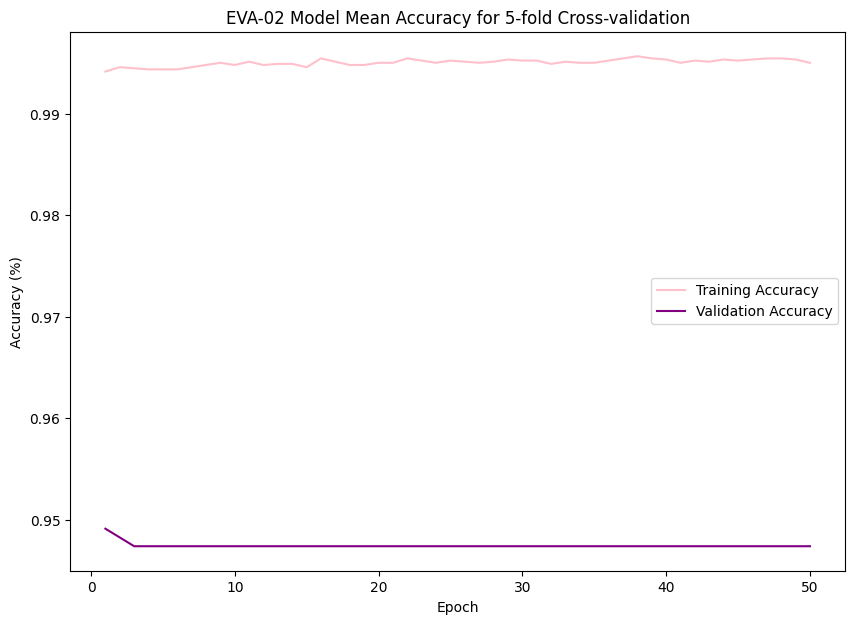

In [ ]:
# Compute mean accuracy across all folds at each epoch
train_acc_mean = np.mean([np.array([acc.cpu() for acc in fold_train_accs[i]]) for i in range(num_folds)], axis=0)
valid_acc_mean = np.mean([np.array([acc.cpu() for acc in fold_valid_accs[i]]) for i in range(num_folds)], axis=0)

# Plot mean accuracy history
plt.figure(figsize=(10, 7))
plt.plot(np.arange(1, num_epochs + 1), train_acc_mean, label='Training Accuracy', color='pink')
plt.plot(np.arange(1, num_epochs + 1), valid_acc_mean, label='Validation Accuracy', color='purple')
plt.title(f'{model_name} Mean Accuracy for {num_folds}-fold Cross-validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [ ]:
# Evaluate the trained model on the test sets for each fold.
avg_test_acc_k_folds = []

def evaluate_accuracy(history, index):
    history_cpu = [item.cpu() for item in history]
    return sum(history_cpu) / len(history_cpu)

for i in range(num_folds):
    test_accuracy = evaluate_accuracy(fold_test_accs[i], 2)
    print(f'Fold {i + 1}/{num_folds}:')
    print(f'\tTest Accuracy: {test_accuracy * 100:.2f}%')
    avg_test_acc_k_folds.append(test_accuracy)

# Compute the average test accuracy over all folds.
overall_test_acc = sum(avg_test_acc_k_folds) / len(avg_test_acc_k_folds)

# Calculate the average and standard deviation of the test accuracy over all folds.
avg_test_acc = np.mean(avg_test_acc_k_folds)
std_test_acc = np.std(avg_test_acc_k_folds)

# Print the average and standard deviation of the test accuracy over all folds.
print(f'\nAverage Test Accuracy over {num_folds}-fold Cross Validation: {avg_test_acc * 100:.2f}% +/- {std_test_acc * 100:.2f}%')

Fold 1/5:
	Test Accuracy: 77.97%
Fold 2/5:
	Test Accuracy: 77.97%
Fold 3/5:
	Test Accuracy: 77.54%
Fold 4/5:
	Test Accuracy: 78.39%
Fold 5/5:
	Test Accuracy: 77.54%

Average Test Accuracy over 5-fold Cross Validation: 77.88% +/- 0.32%


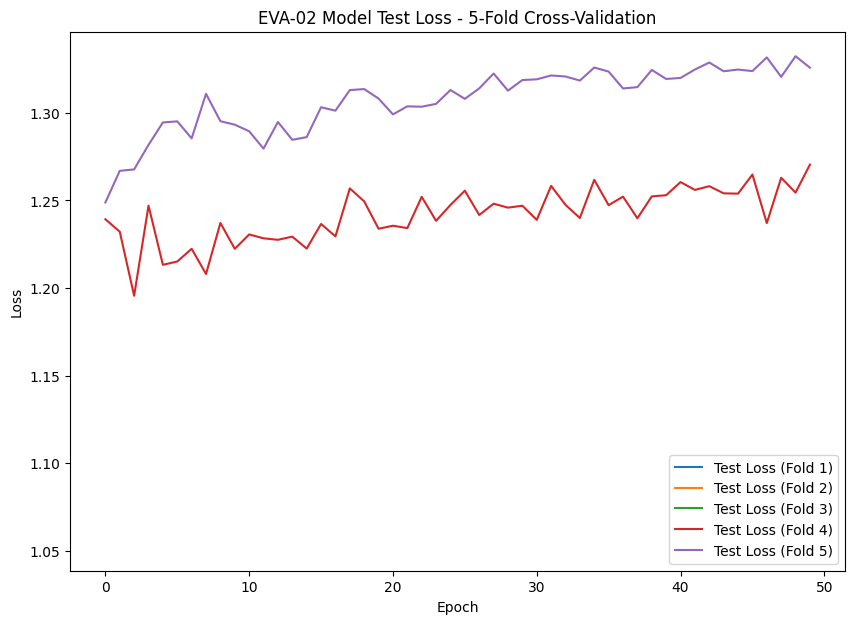

In [ ]:
# Plot the test loss for each epoch
plt.figure(figsize=(10, 7))
for fold in range(num_folds):
    plt.plot(fold_test_losses[fold], label=f'Test Loss (Fold {fold+1})')

plt.title(f'{model_name} Test Loss - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

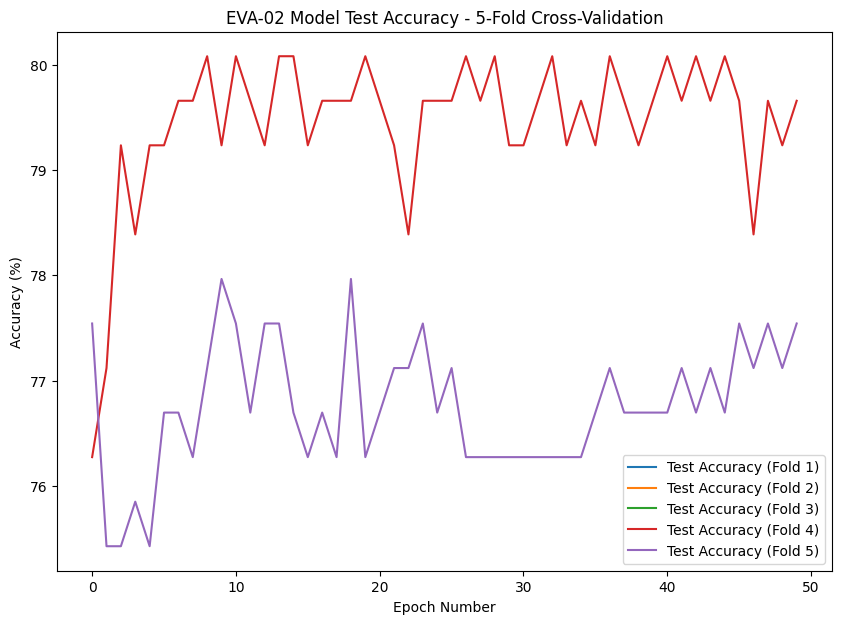

In [ ]:
# Plot the test accuracy for each epoch
plt.figure(figsize=(10, 7))
for fold in range(num_folds):
    plt.plot(np.array([acc.cpu() for acc in fold_test_accs[fold]]) * 100, label=f'Test Accuracy (Fold {fold+1})')

plt.title(f'{model_name} Test Accuracy - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [ ]:
print("Classes: ")
class_names = test_dataset.classes
print(test_dataset.classes)

Classes: 
['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'grape leaf', 'grape leaf black rot']


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# สมมุติว่า `model` คือโมเดลที่คุณได้ทำการฝึกฝนเสร็จสิ้นแล้ว
# และ `test_loader` คือ DataLoader สำหรับข้อมูลทดสอบ

all_labels, all_preds = [], []
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

    all_labels.extend(labels.tolist())
    all_preds.extend(preds.tolist())

# พิมพ์ confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  8  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  1  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  7  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
   0  0  0]
 [ 0  1  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 1  2  0  0  0  0  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  1  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  7  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  1  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 

In [ ]:
# พิมพ์ classification report ซึ่งจะบอก precision, recall และ F1-score
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
                             precision    recall  f1-score   support

           Apple Scab Leaf       0.91      1.00      0.95        10
                Apple leaf       0.67      0.89      0.76         9
           Apple rust leaf       0.90      0.90      0.90        10
          Bell_pepper leaf       0.88      0.88      0.88         8
     Bell_pepper leaf spot       0.80      0.89      0.84         9
            Blueberry leaf       0.91      0.91      0.91        11
               Cherry leaf       1.00      0.70      0.82        10
       Corn Gray leaf spot       0.11      0.25      0.15         4
          Corn leaf blight       0.62      0.42      0.50        12
            Corn rust leaf       1.00      0.90      0.95        10
                Peach leaf       1.00      1.00      1.00         9
  Potato leaf early blight       0.44      0.50      0.47         8
   Potato leaf late blight       0.60      0.38      0.46         8
            Raspberry l

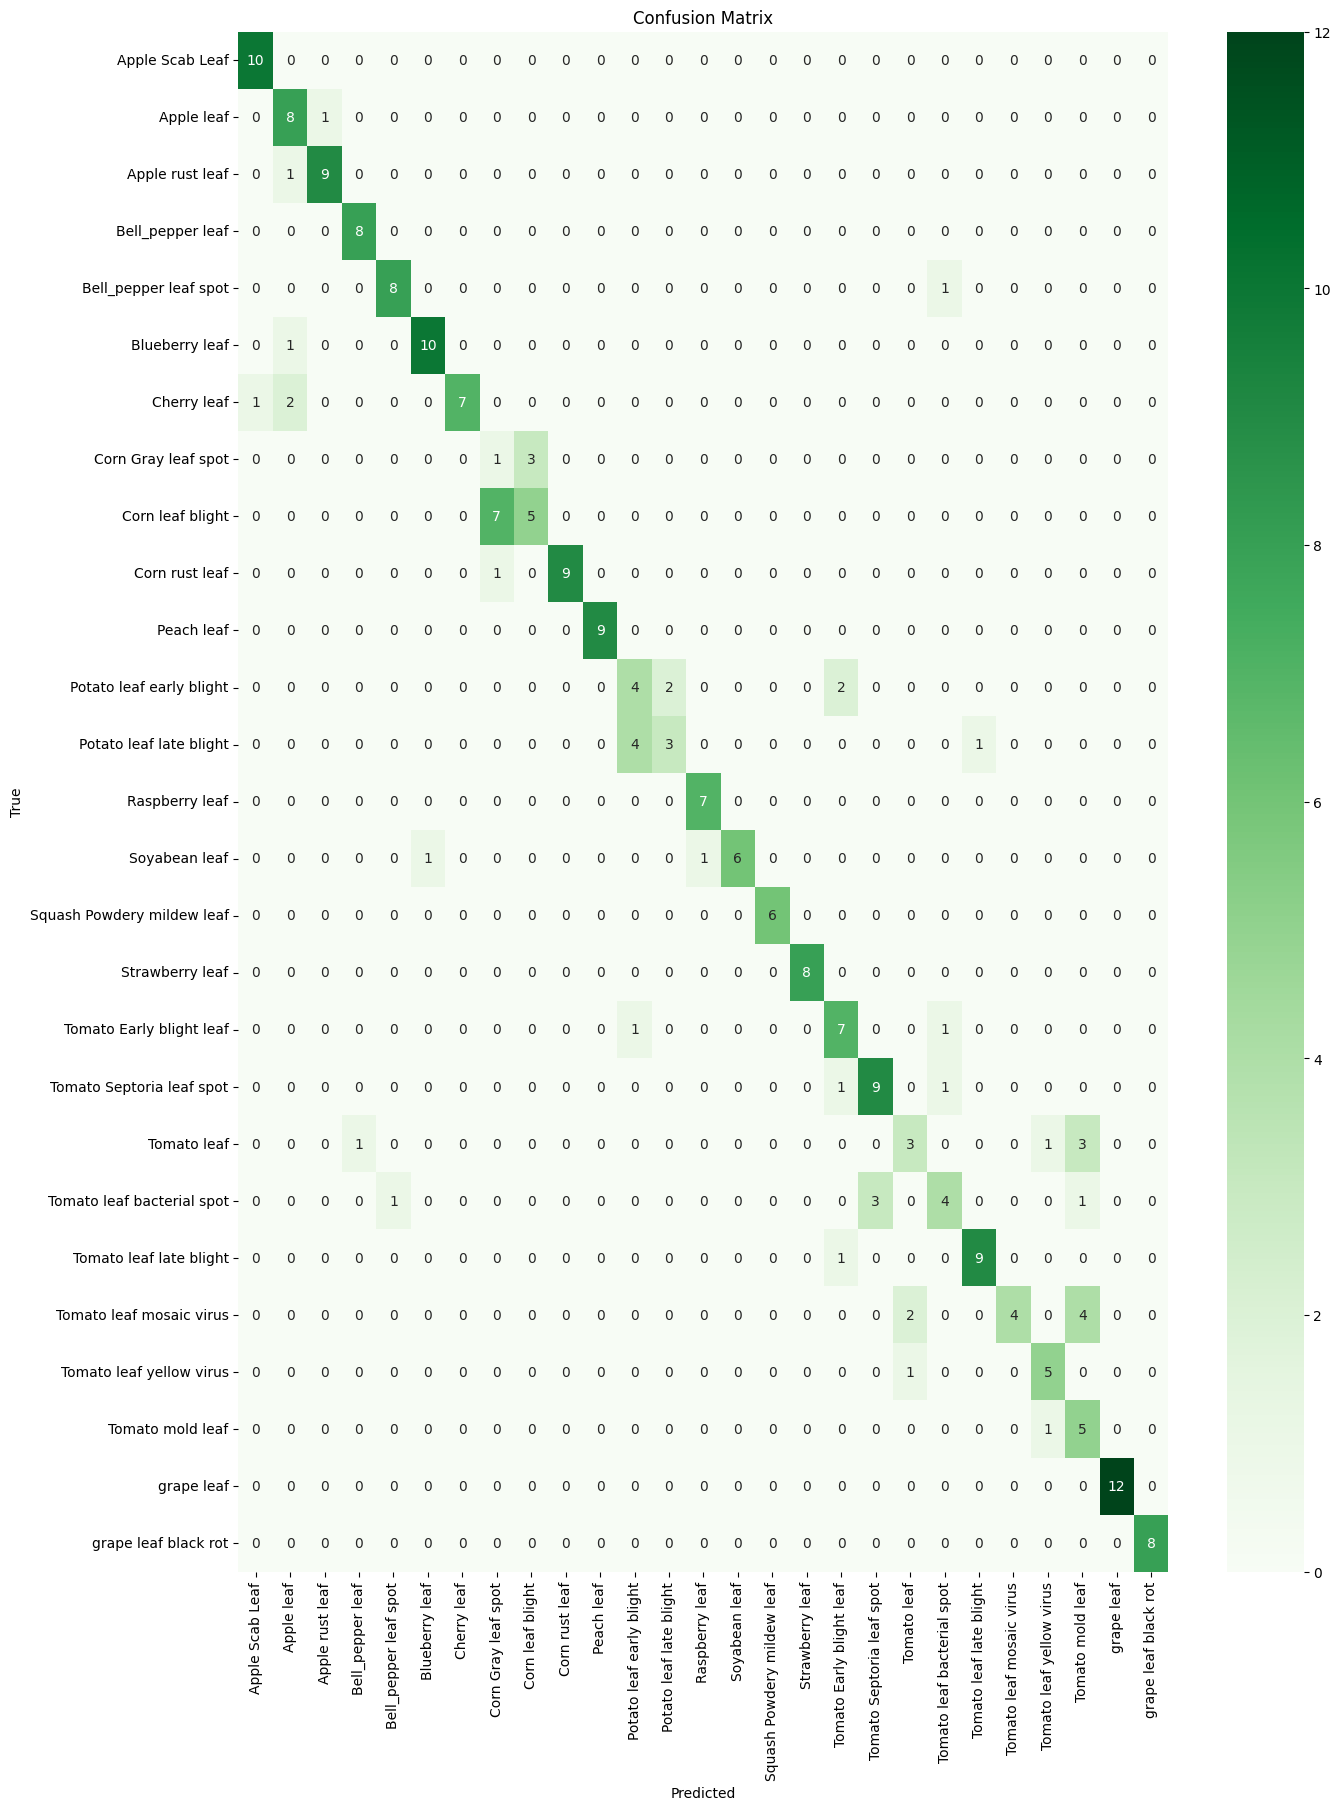

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(15, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

<ipython-input-24-af32650244a3>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm_total = cm.astype(np.float).sum(axis=1)


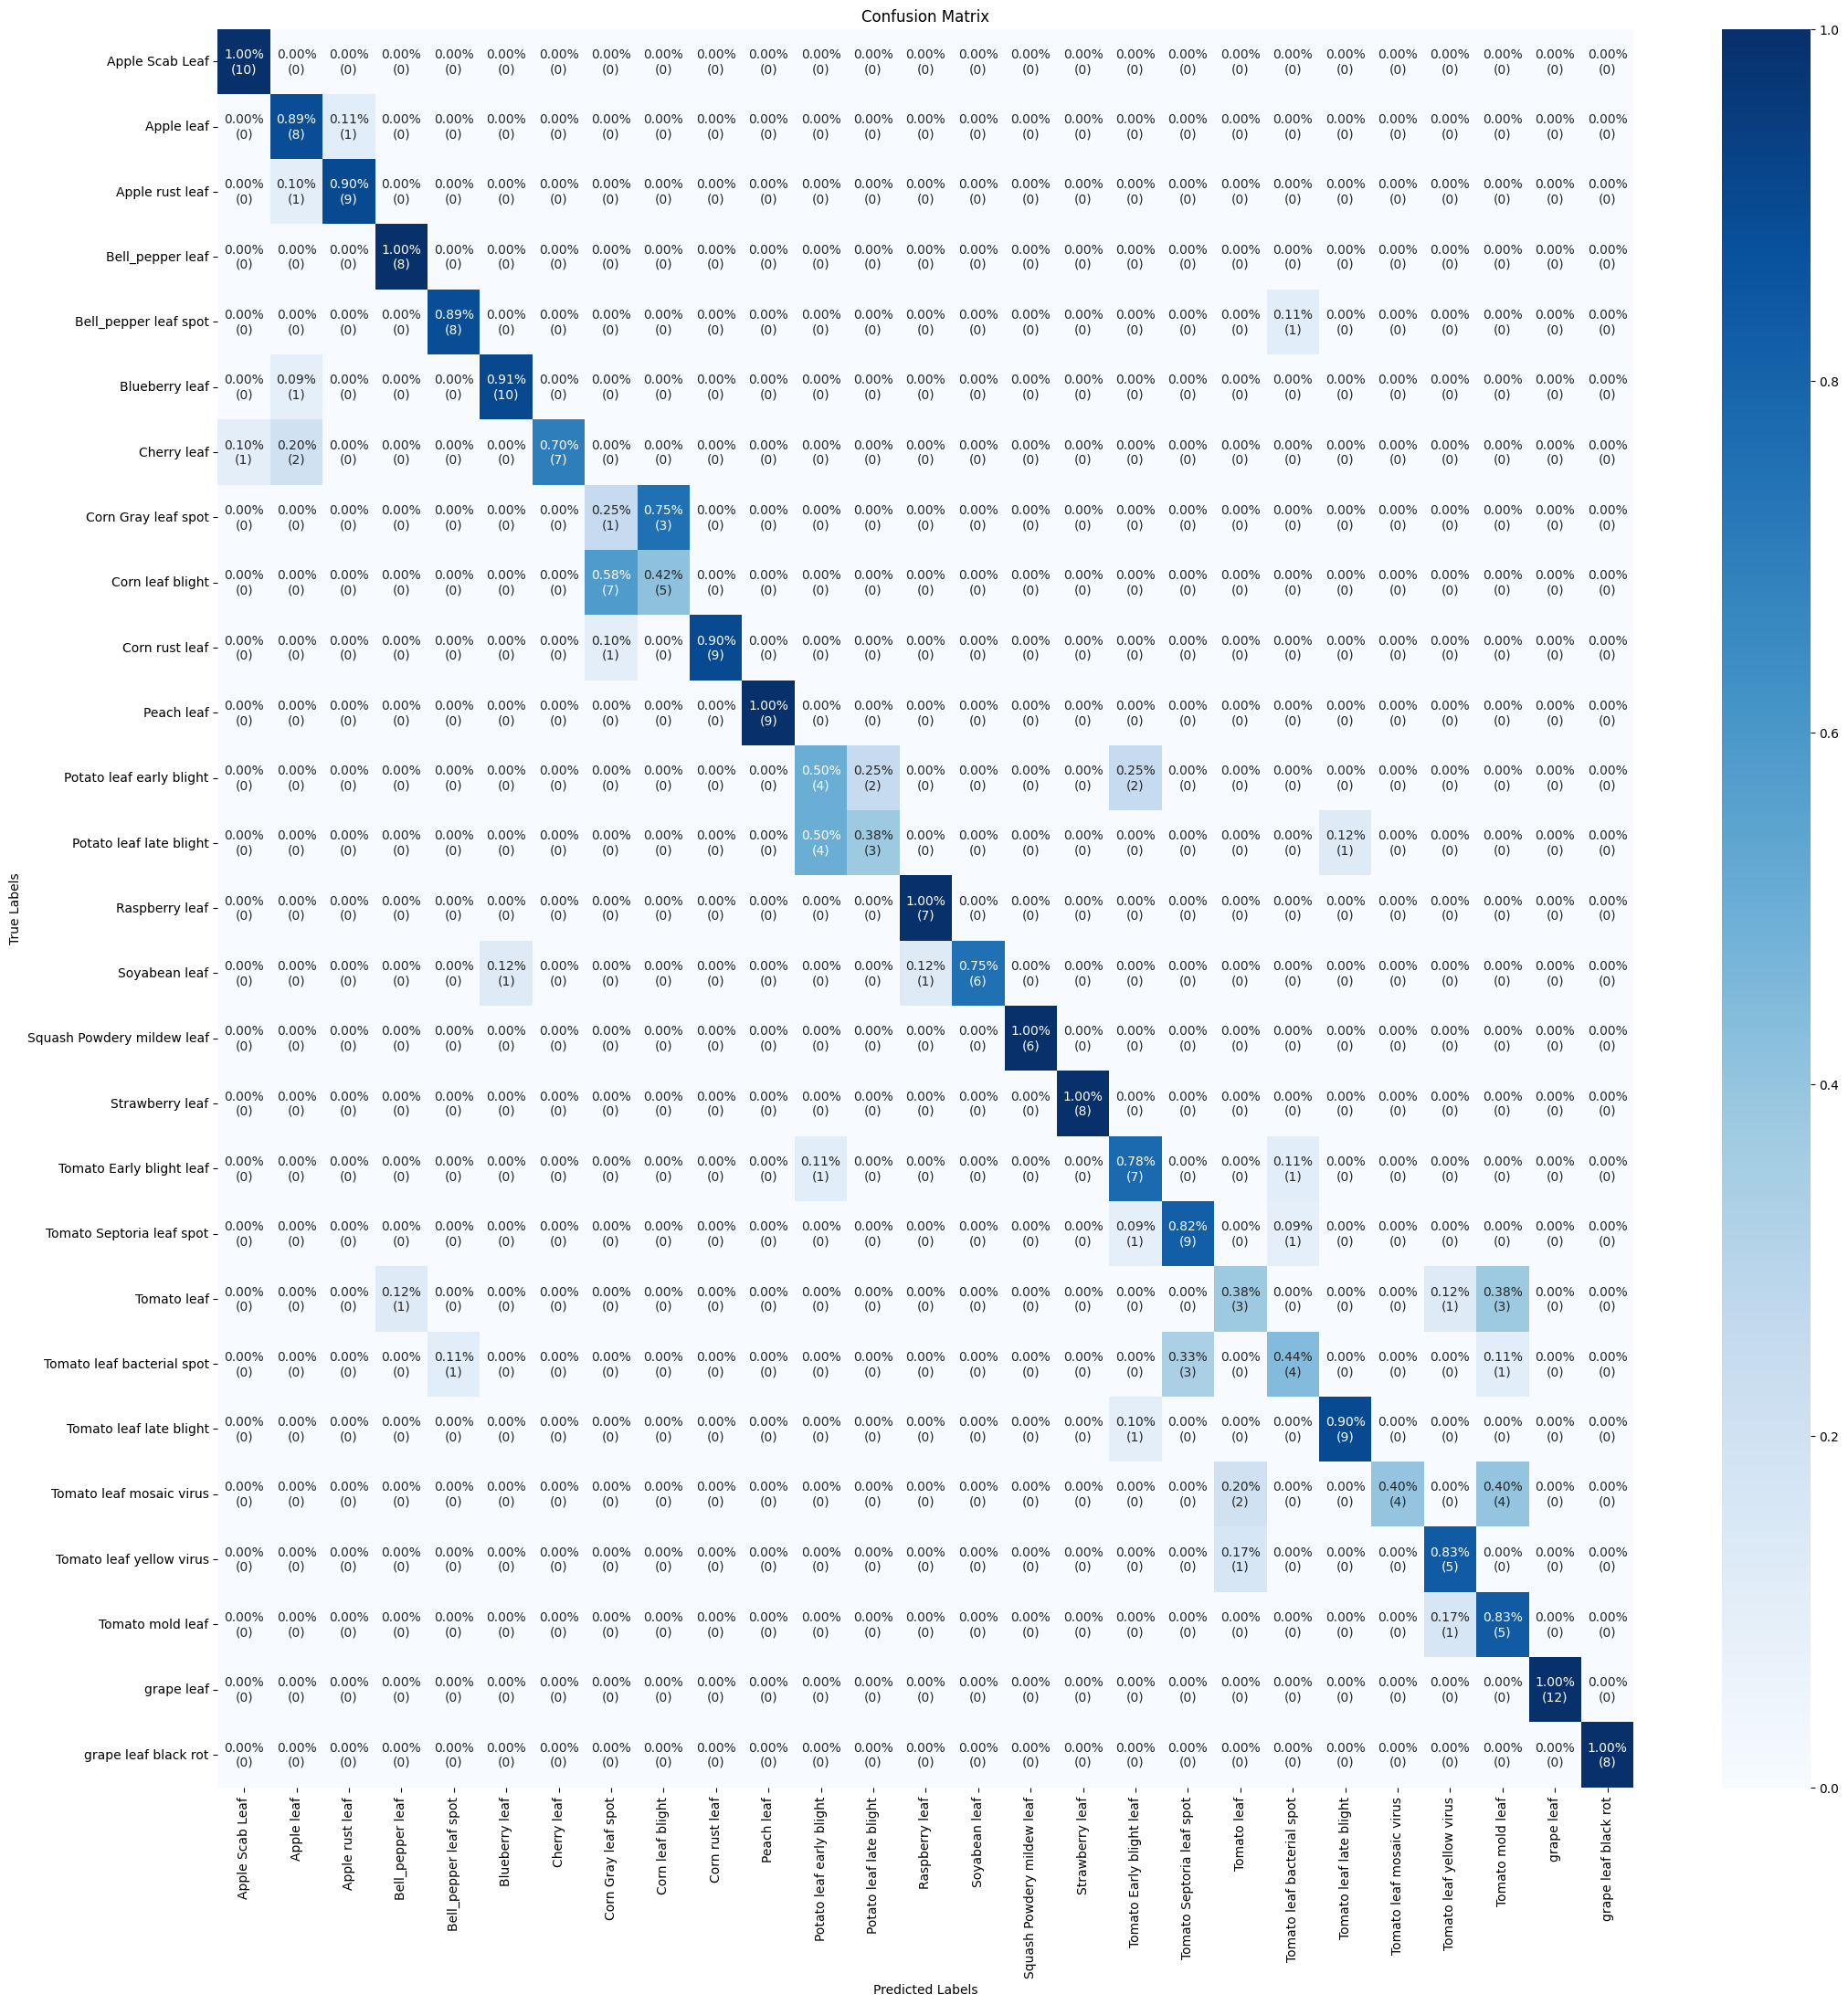

In [ ]:
def fmt(p, total):
    return '{:.2f}%\n({:.0f})'.format(p, total)

# Compute normalized confusion matrix
cm_total = cm.astype(np.float).sum(axis=1)
cm_normalized = cm.astype('float') / cm_total[:, np.newaxis]

# Compute annotations
annotations = np.vectorize(fmt)(cm_normalized, cm)

fig, ax = plt.subplots(figsize=(25, 25))
sns.heatmap(cm_normalized, annot=annotations, fmt='', cmap='Blues', ax=ax,
            xticklabels=class_names, yticklabels=class_names)
ax.set_title("Confusion Matrix")
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

plt.show()

In [ ]:
correct_samples = {class_name: [] for class_name in class_names}
incorrect_samples = {class_name: [] for class_name in class_names}

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        scores = torch.nn.functional.softmax(outputs, dim=1) * 100 # compute softmax scores

        # Iterate over the batch
        for input_image, true_label, pred_label, score in zip(inputs, labels, preds, scores):
            class_name = class_names[true_label.item()]
            if true_label == pred_label:
                # Correct prediction
                correct_samples[class_name].append((input_image.cpu(), class_names[pred_label.item()], score[pred_label.item()].item()))
            else:
                # Incorrect prediction
                incorrect_samples[class_name].append((input_image.cpu(), class_names[pred_label.item()], score[pred_label.item()].item()))

In [ ]:
def imshow(ax, inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title, fontsize=12)

# Create separate grid for each class
for i, class_name in enumerate(class_names):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for j in range(5):
        if j < len(correct_samples[class_name]):
            imshow(axes[0, j], correct_samples[class_name][j][0], title=f"Pred: {correct_samples[class_name][j][1]}\nTrue: {class_name}\nScore: {correct_samples[class_name][j][2]:.4f}%")
        else:  # In case we don't have enough correct samples
            axes[0, j].axis('off')

        if j < len(incorrect_samples[class_name]):
            imshow(axes[1, j], incorrect_samples[class_name][j][0], title=f"Pred: {incorrect_samples[class_name][j][1]}\nTrue: {class_name}\nScore: {incorrect_samples[class_name][j][2]:.4f}%")
        else:  # In case we don't have enough incorrect samples
            axes[1, j].axis('off')

    axes[0, 0].set_ylabel("Correct samples")
    axes[1, 0].set_ylabel("Incorrect samples")

    # Add class name as a big title for each class
    fig.suptitle(class_name, fontsize=16)

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# เตรียมข้อมูล
inputs = torch.randn(1, 3, 224, 224)
if torch.cuda.is_available():
    inputs = inputs.to(device)

# ติดตั้ง hook
gradients = []
activations = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# ติดตั้ง hook ให้ชั้นที่ต้องการ
# สมมุติว่า 'blocks' เป็นชื่อชั้นที่ต้องการในโมเดล EVA
# และเราต้องการบันทึกจาก block ที่ 23
model.blocks[23].register_forward_hook(forward_hook)
model.blocks[23].register_backward_hook(backward_hook)

In [ ]:
import cv2
import torch.nn.functional as F

# กำหนดขนาดของ subplots โดยการคำนวณจากจำนวน total_samples ที่คุณมี
total_samples = sum([len(samples) for _, samples in incorrect_samples.items()])
fig, axes = plt.subplots(nrows=(total_samples // 5) + 1, ncols=5, figsize=(25, 5 * (total_samples // 5 + 1)))

current_row = 0
current_col = 0

for class_name, samples in incorrect_samples.items():
    for sample in samples:
        img_tensor, predicted_label, score = sample

        img_tensor = img_tensor.to(device).unsqueeze(0)
        gradients.clear()
        activations.clear()
        output = model(img_tensor)
        output = F.softmax(output, dim=1)
        prediction = output.argmax(dim=1)
        model.zero_grad()
        output[0, prediction[0]].backward()

        gradient = gradients[0].to(device)
        activation = activations[0].to(device)
        weights = gradient.mean(dim=[1, 2], keepdim=True)
        grad_cam = F.relu((weights * activation).sum(dim=1, keepdim=True))
        grad_cam = grad_cam.to(device)

        grad_cam_img = grad_cam[0].squeeze().detach().cpu().numpy()
        grad_cam_img = cv2.resize(grad_cam_img, (224, 224))
        grad_cam_img = (grad_cam_img - grad_cam_img.min()) / (grad_cam_img.max() - grad_cam_img.min())
        grad_cam_img = cv2.applyColorMap(np.uint8(255 * grad_cam_img), cv2.COLORMAP_JET)

        original_img = img_tensor[0].permute(1, 2, 0).cpu().numpy()
        original_img = (original_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
        original_img = original_img.astype(np.float32) / 255.0
        grad_cam_img = grad_cam_img.astype(np.float32) / 255.0
        overlay_img = cv2.addWeighted(original_img, 0.5, grad_cam_img, 0.5, 0)
        overlay_img = np.clip(overlay_img, 0, 1)

        axes[current_row, current_col].imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
        axes[current_row, current_col].set_title(f"True: {class_name}\nPredicted: {predicted_label}\nScore: {score:.4f}")
        axes[current_row, current_col].axis('off')

        # กำหนดตำแหน่งในการแสดงรูปภาพถัดไป
        current_col += 1
        if current_col > 4:
            current_col = 0
            current_row += 1

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# After backward pass
gradient = gradients[0]
print("Gradient shape:", gradient.shape)  # Check the shape of the gradient tensor

# Adjust the dimensions in the .mean() call based on the shape
# For example, if the gradient tensor has shape [num_channels, height, width]
weights = gradient.mean(dim=[1, 2], keepdim=True)

# Rest of your code...


Gradient shape: torch.Size([1, 257, 1024])


In [ ]:
# Dictionary to hold the features
features = {}

# Function to recursively apply hooks to all modules
def register_hooks(module):
    if len(list(module.children())) == 0:  # It's a leaf module
        module.register_forward_hook(get_features(module))
    else:
        for child in module.children():
            register_hooks(child)

# Function to create hooks
def get_features(module):
    def hook(module, input, output):
        features[type(module).__name__] = output.detach()
    return hook

# Register hooks on all modules
register_hooks(model)

# Forward pass
model(inputs)

# Now you can process or visualize these features as needed
# For example, to print the shapes of all feature maps:
for name, feature in features.items():
    print(f"{name}: {feature.shape}")

Conv2d: torch.Size([12, 1024, 16, 16])
Identity: torch.Size([12, 257, 1024])
Dropout: torch.Size([12, 1024])
LayerNorm: torch.Size([12, 1024])
Linear: torch.Size([12, 27])
SiLU: torch.Size([12, 257, 2730])


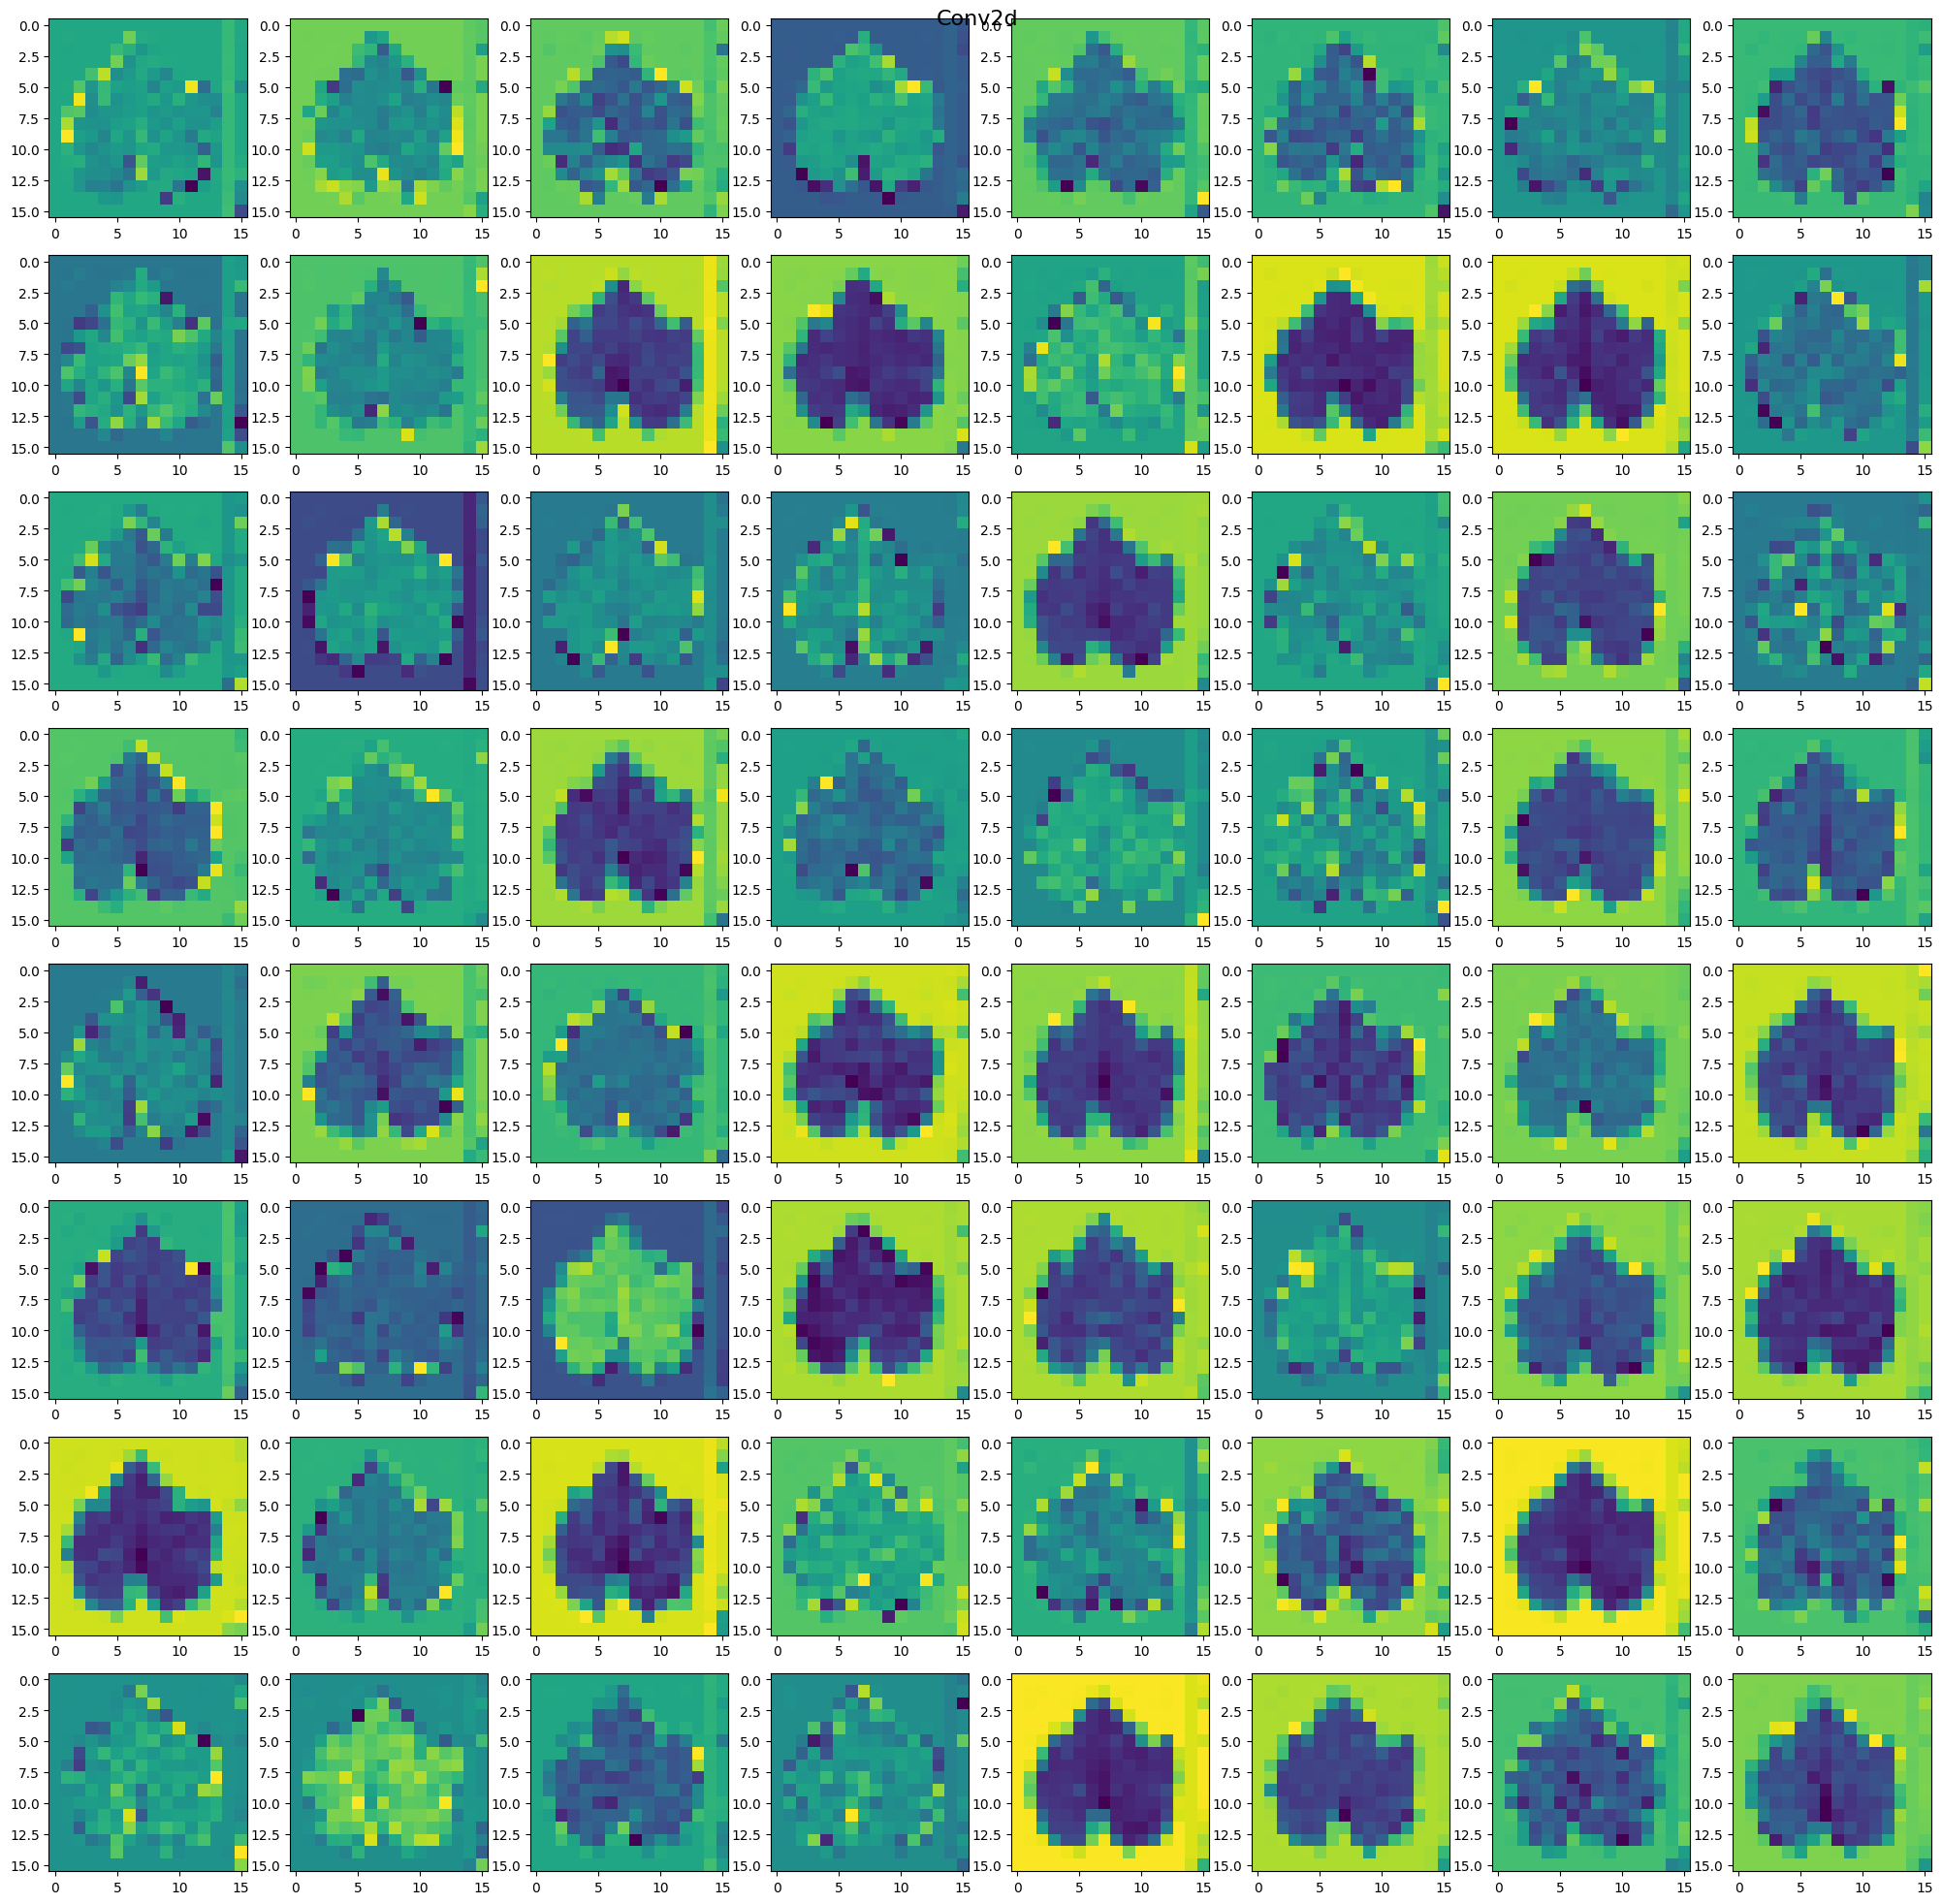

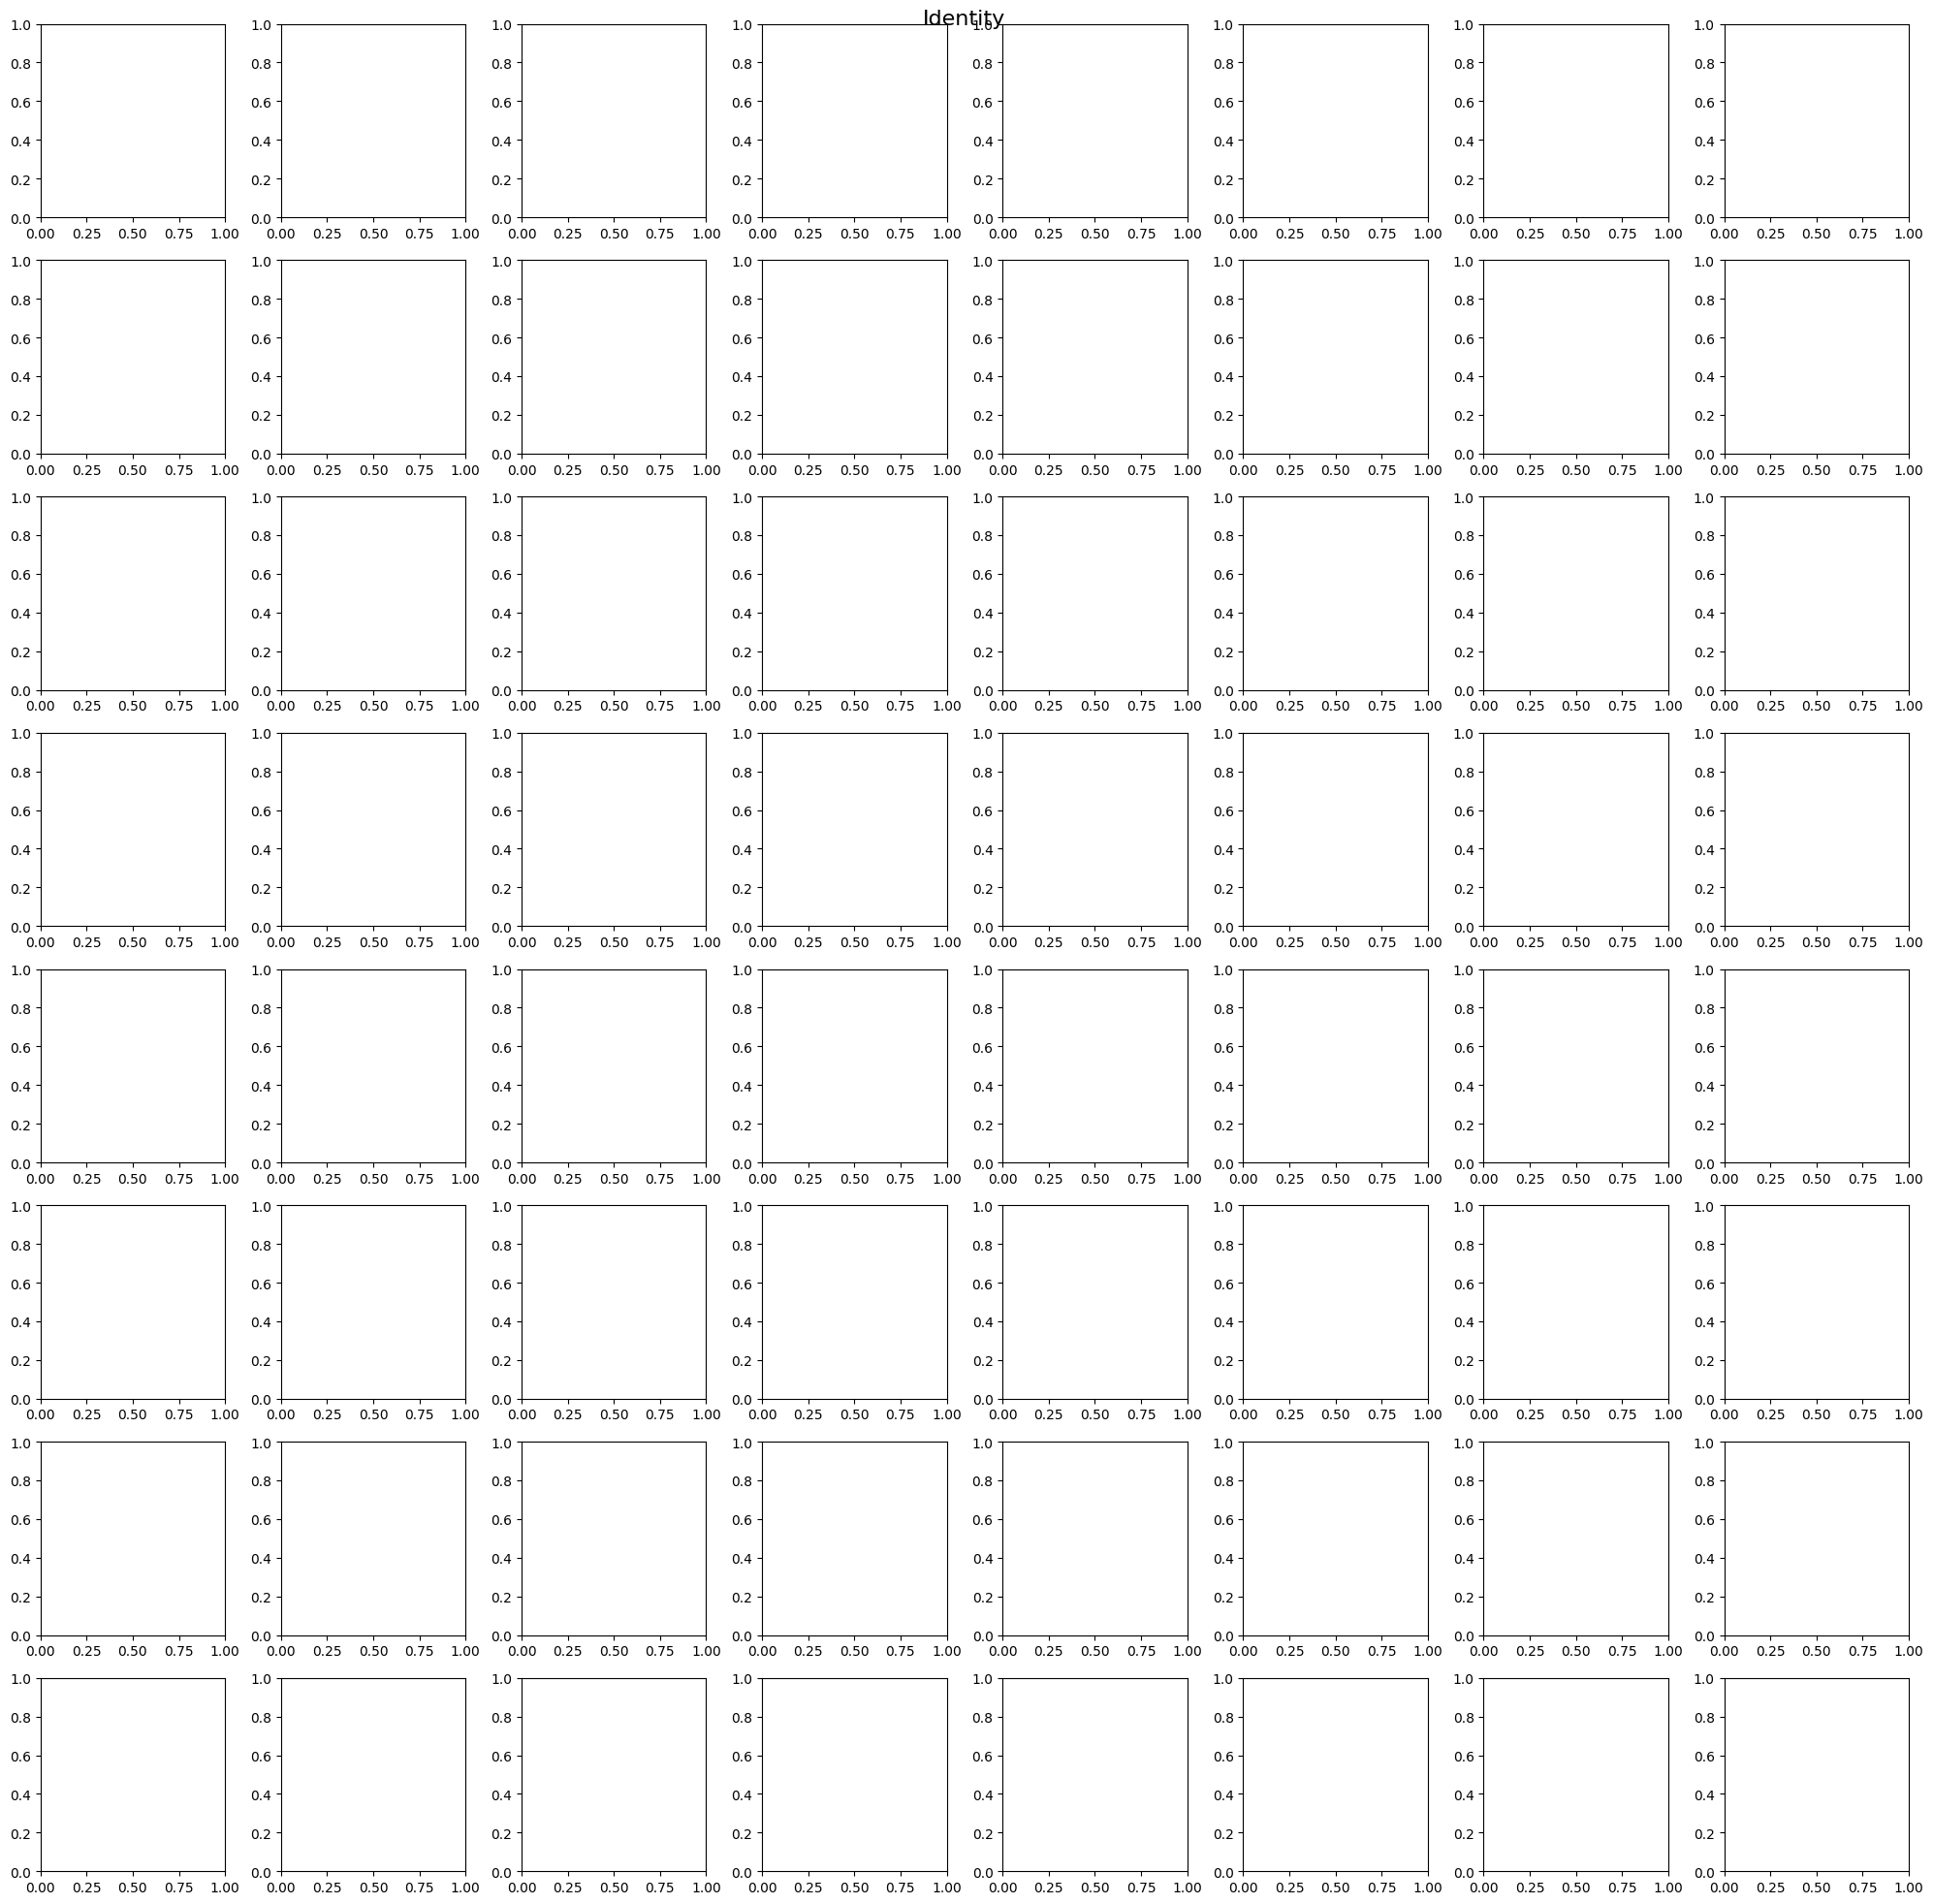

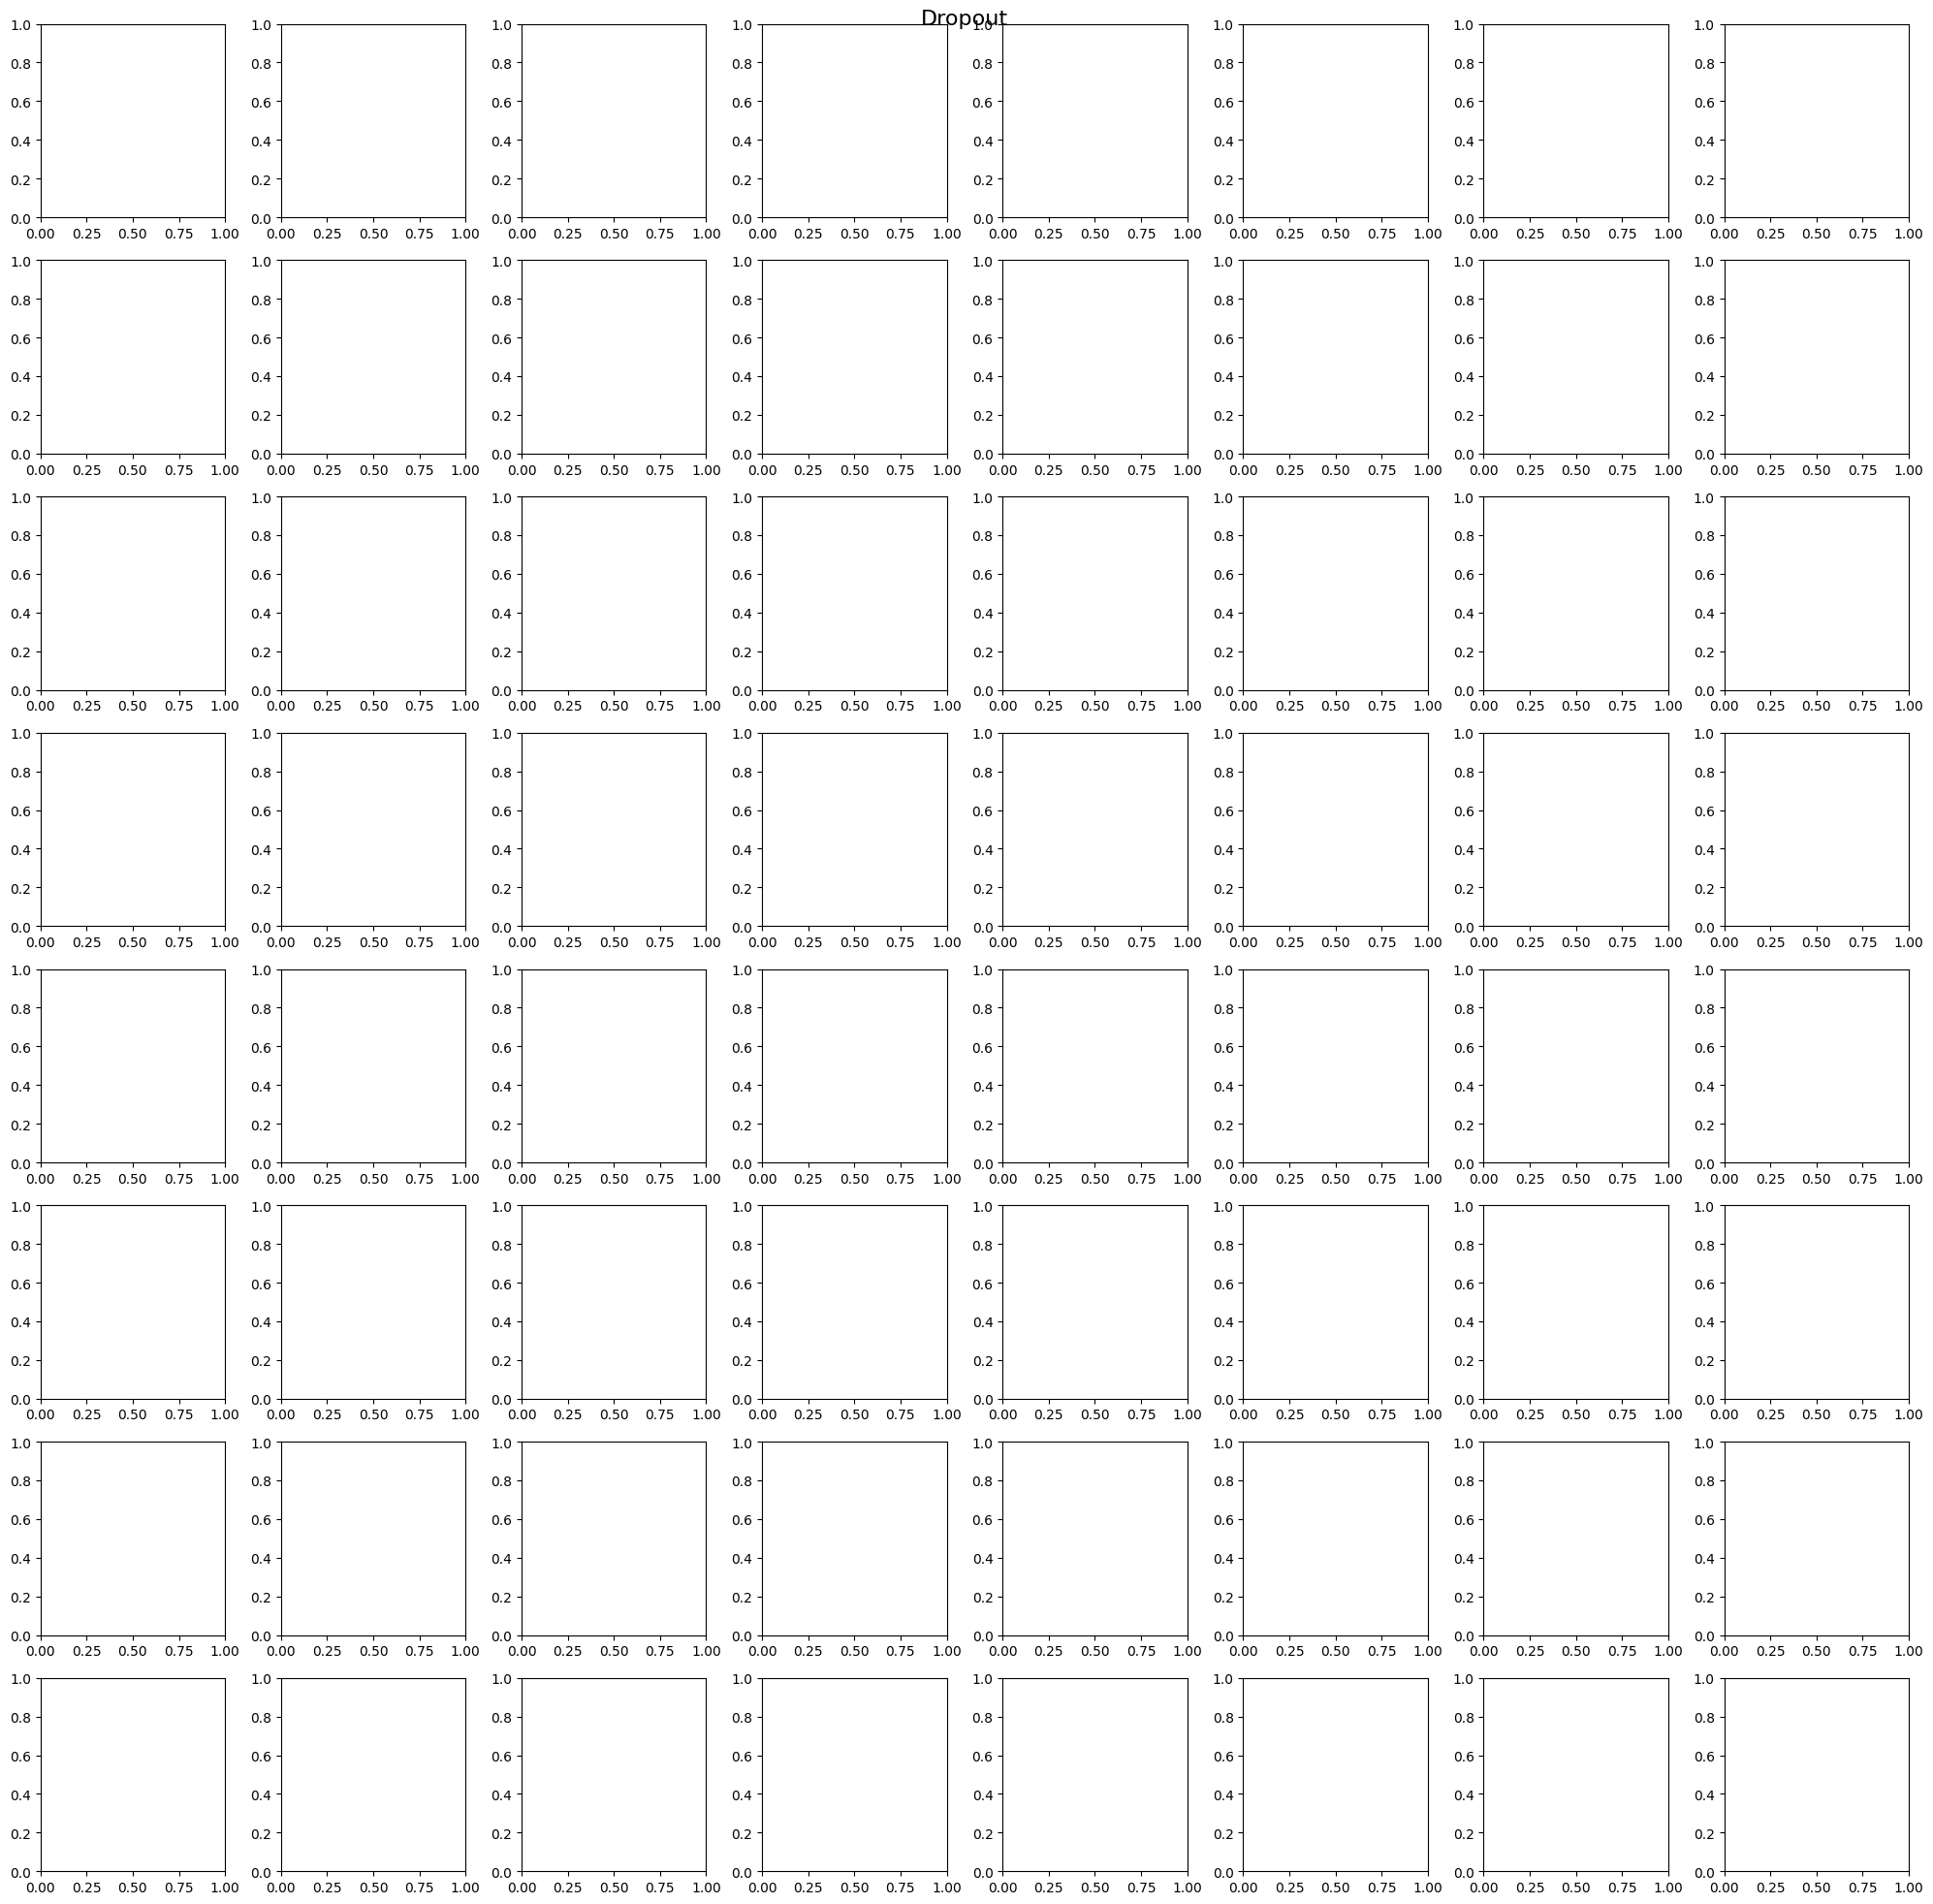

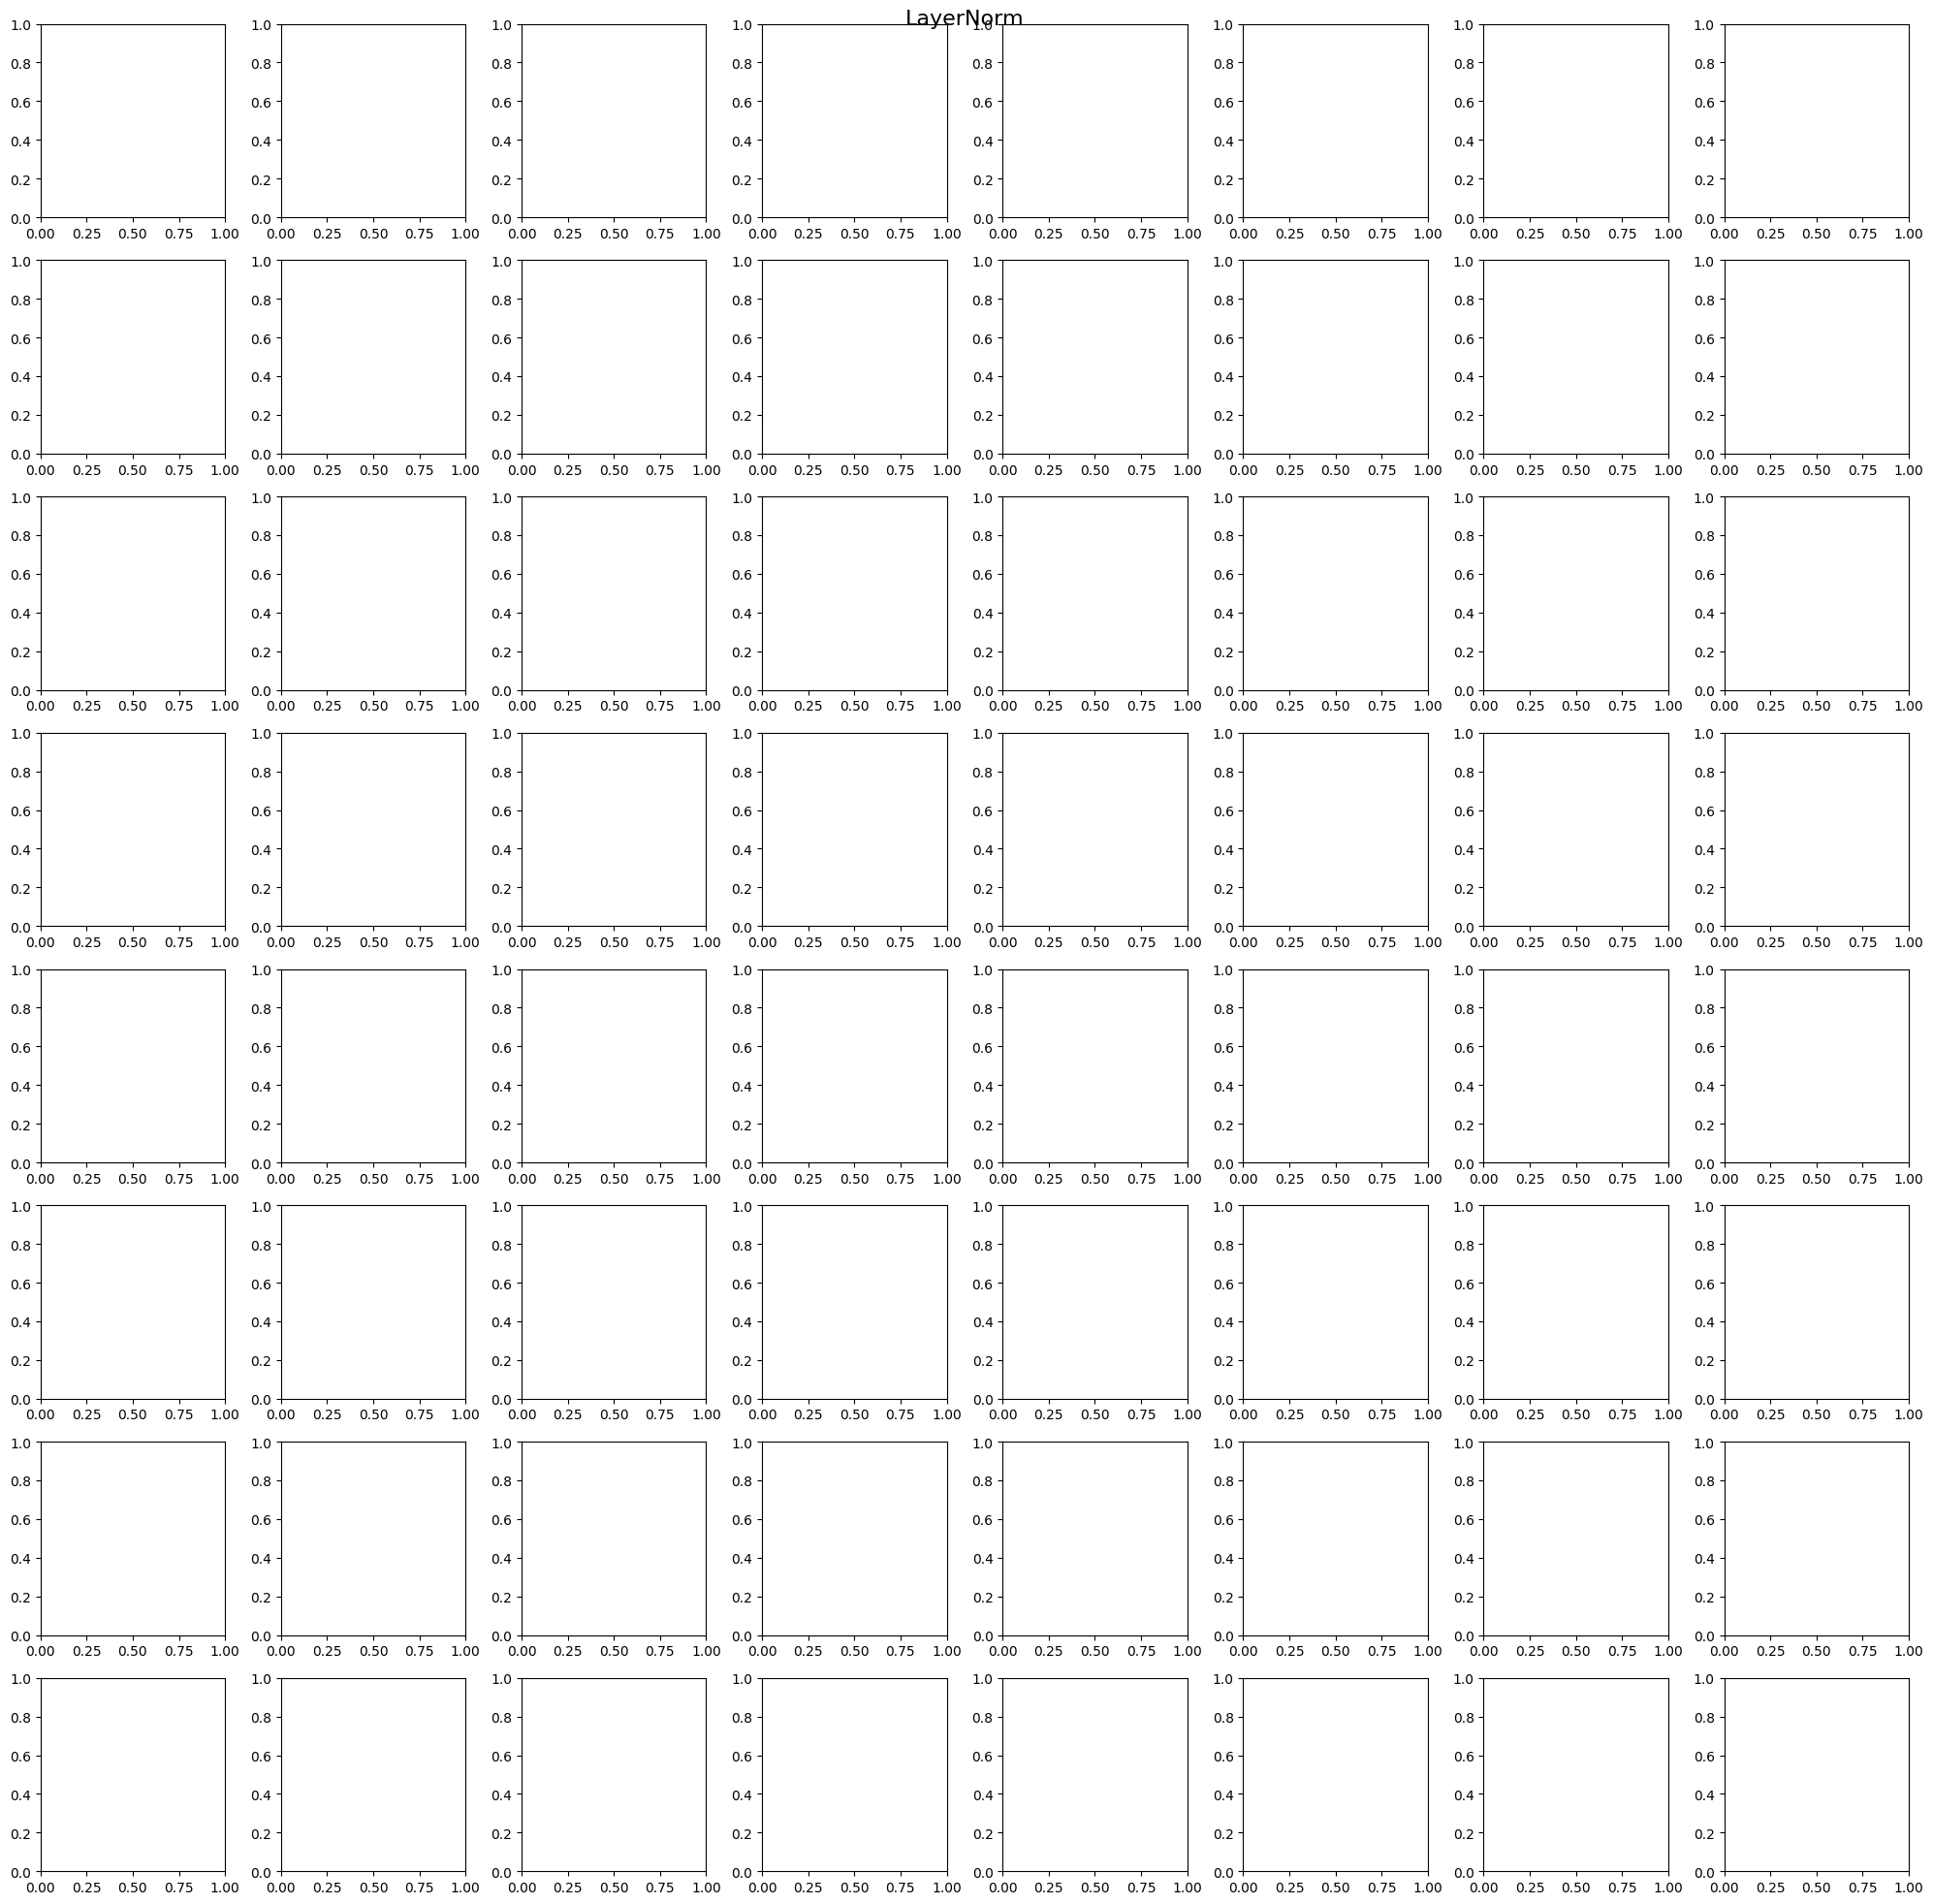

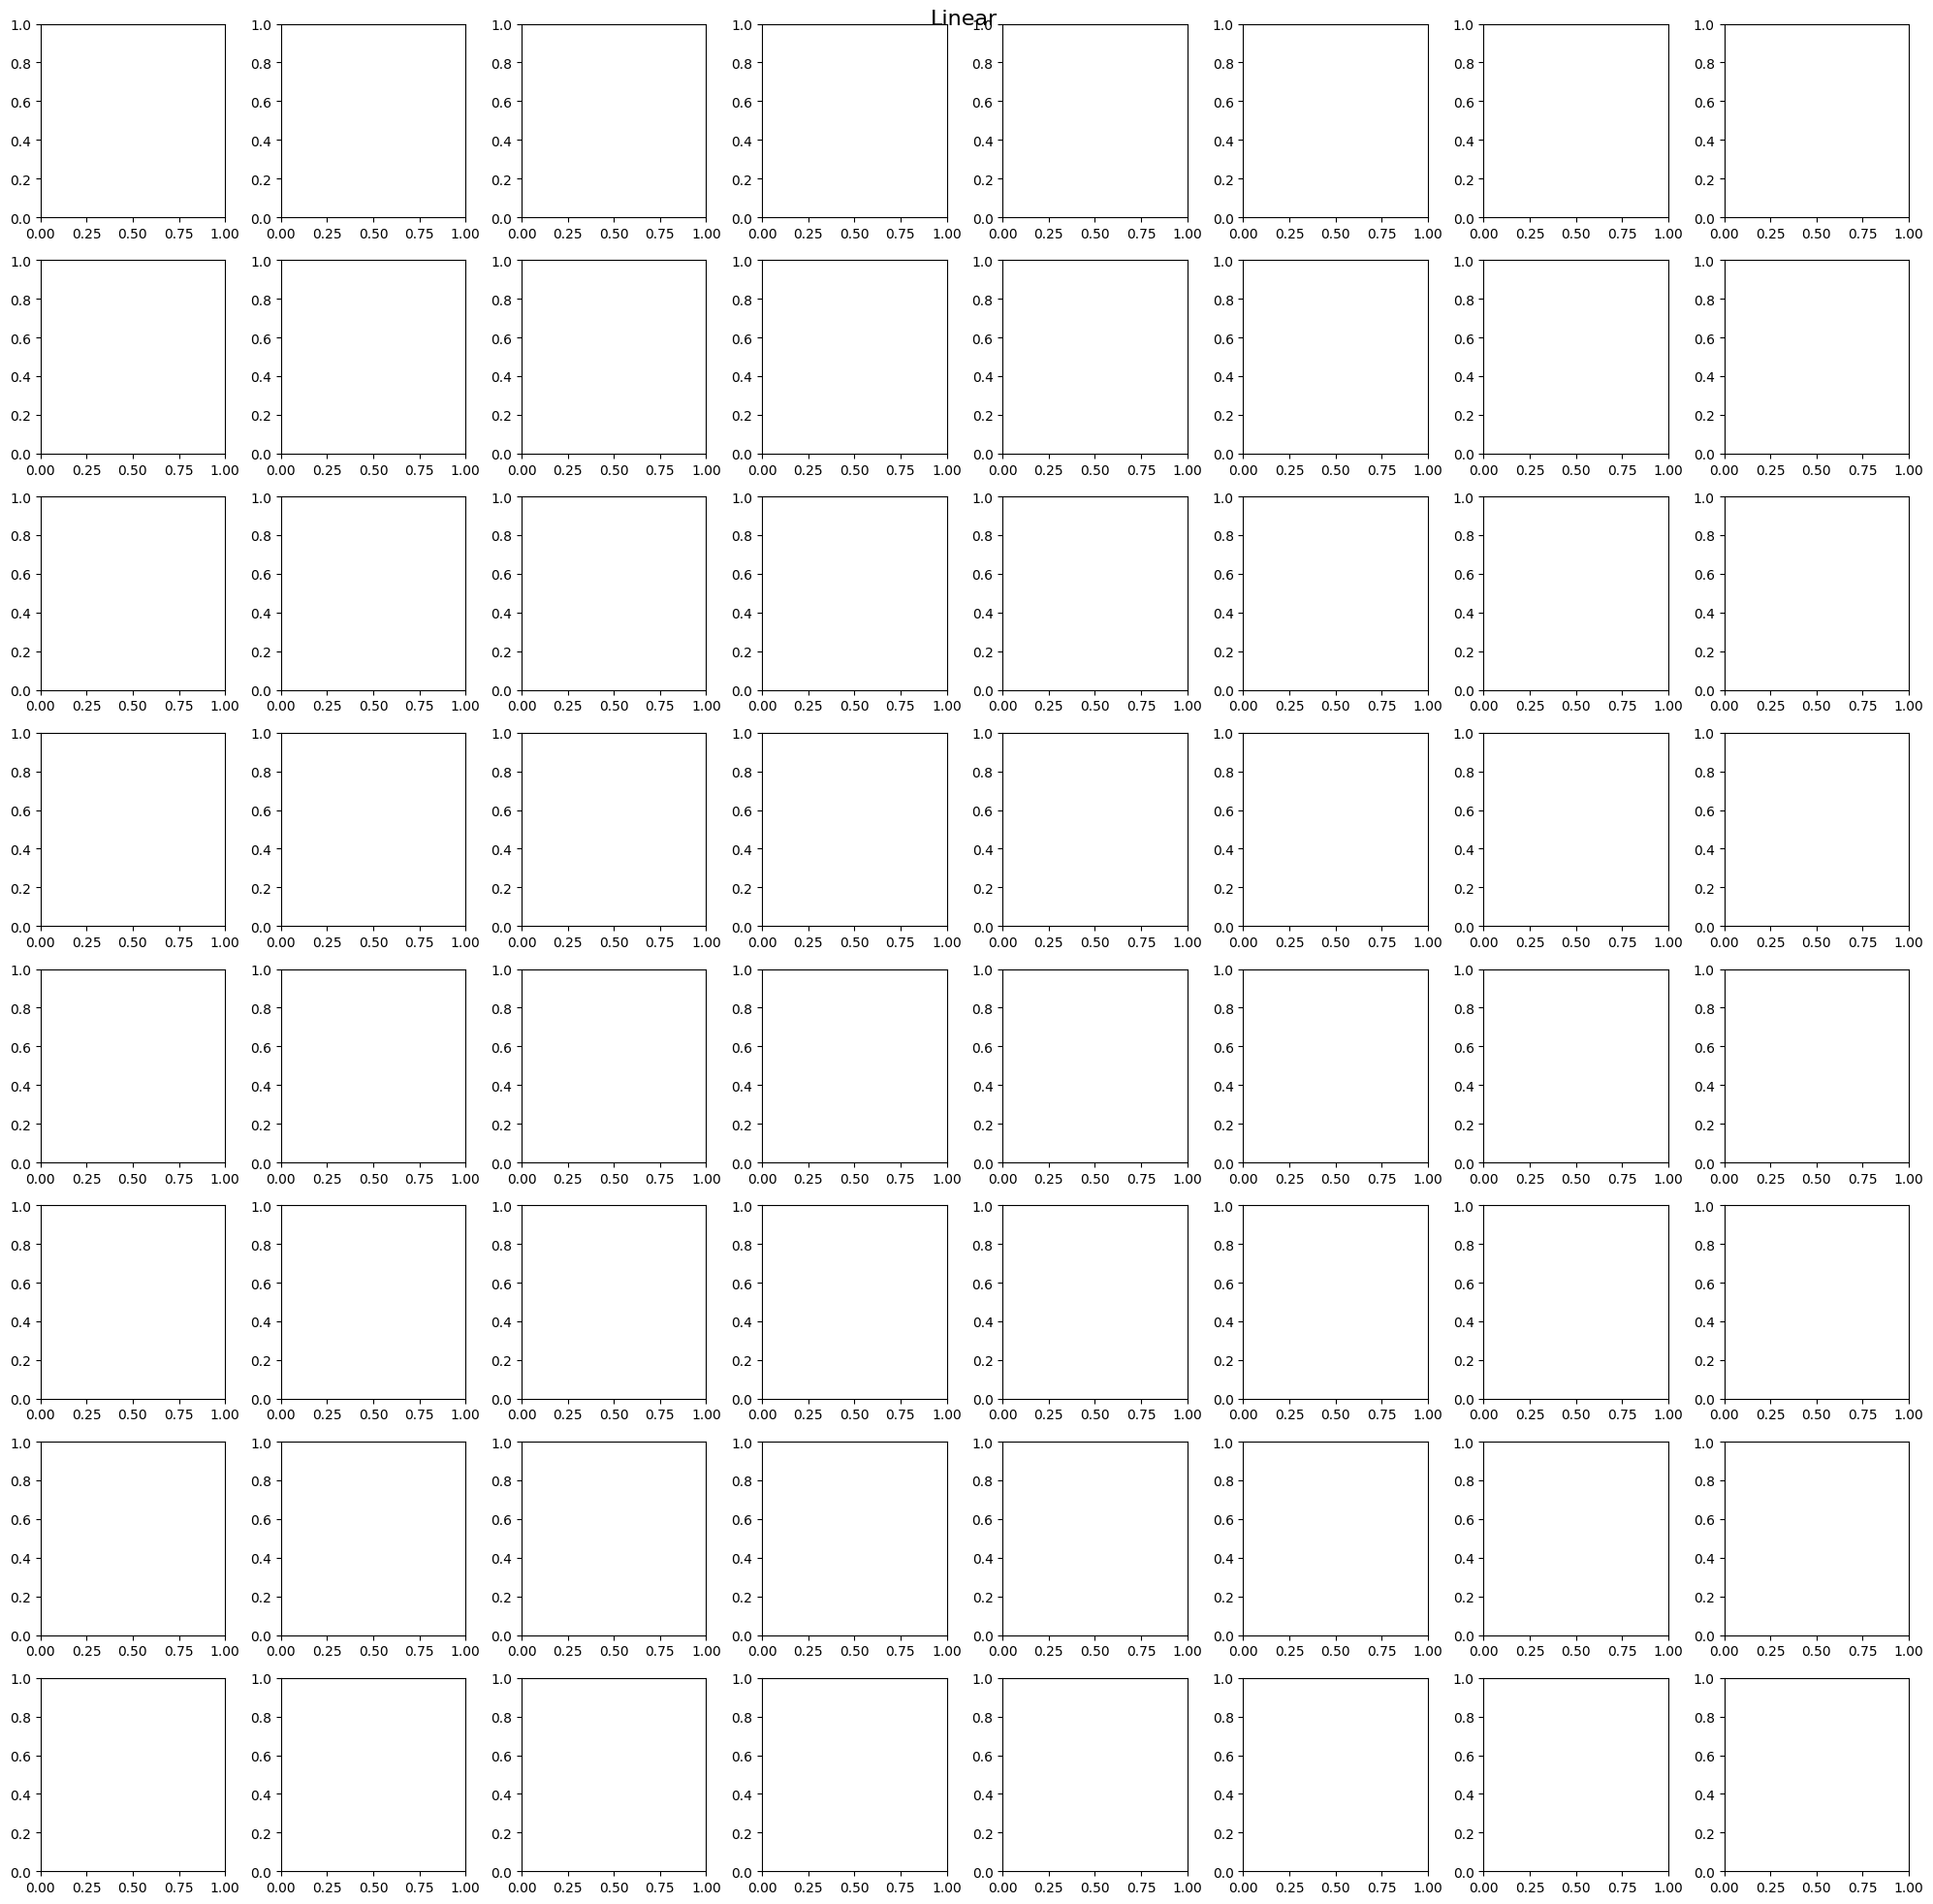

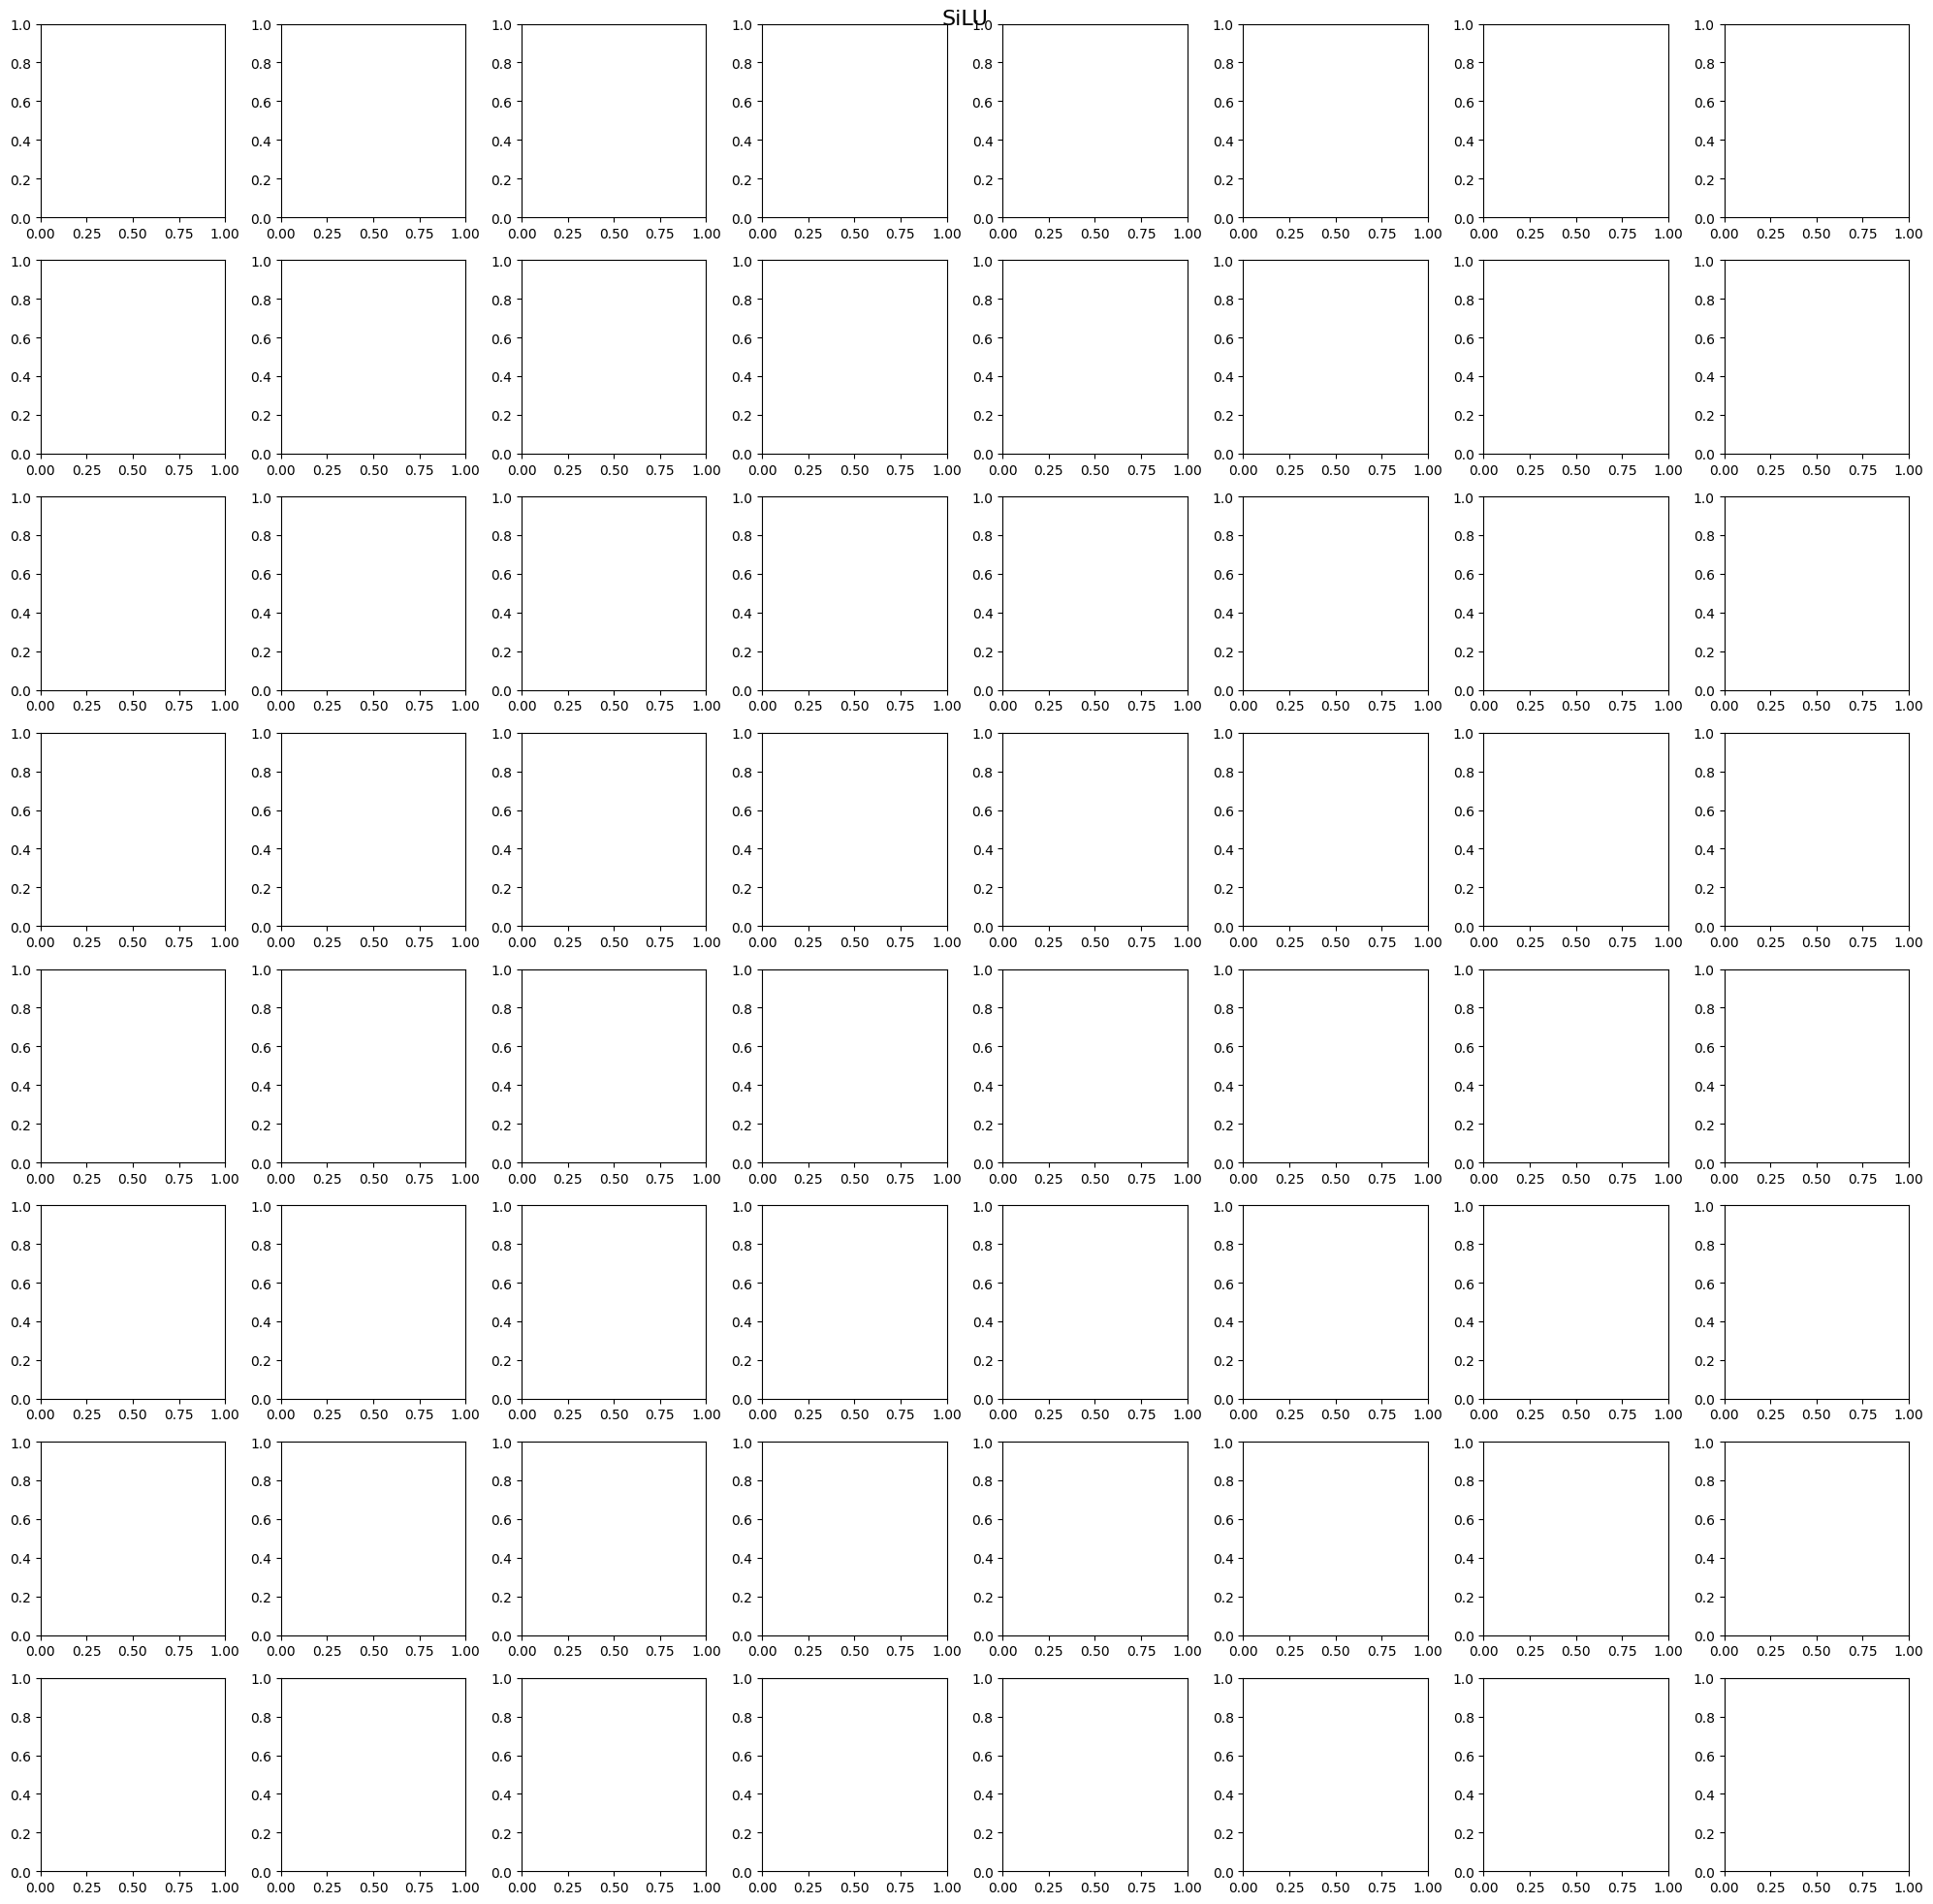

In [ ]:
for layer_name, maps in features.items():
    fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(20, 20))
    fig.suptitle(layer_name, fontsize=16)
    for i, ax in enumerate(axes.flat):
        # ตรวจสอบว่า feature map มีมิติที่เหมาะสมหรือไม่
        if i < maps.shape[1] and len(maps[0][i].shape) == 2:
            ax.imshow(maps[0][i].detach().cpu().numpy(), cmap='viridis')
        ax.axis()
    plt.tight_layout()
    plt.show()

In [ ]:
# แสดงรายชื่อชั้นทั้งหมดในโมเดล
for name, module in model.named_modules():
    print(name)


patch_embed
patch_embed.proj
patch_embed.norm
pos_drop
rope
blocks
blocks.0
blocks.0.norm1
blocks.0.attn
blocks.0.attn.q_proj
blocks.0.attn.k_proj
blocks.0.attn.v_proj
blocks.0.attn.attn_drop
blocks.0.attn.norm
blocks.0.attn.proj
blocks.0.attn.proj_drop
blocks.0.drop_path1
blocks.0.norm2
blocks.0.mlp
blocks.0.mlp.fc1_g
blocks.0.mlp.fc1_x
blocks.0.mlp.act
blocks.0.mlp.drop1
blocks.0.mlp.norm
blocks.0.mlp.fc2
blocks.0.mlp.drop2
blocks.0.drop_path2
blocks.1
blocks.1.norm1
blocks.1.attn
blocks.1.attn.q_proj
blocks.1.attn.k_proj
blocks.1.attn.v_proj
blocks.1.attn.attn_drop
blocks.1.attn.norm
blocks.1.attn.proj
blocks.1.attn.proj_drop
blocks.1.drop_path1
blocks.1.norm2
blocks.1.mlp
blocks.1.mlp.fc1_g
blocks.1.mlp.fc1_x
blocks.1.mlp.act
blocks.1.mlp.drop1
blocks.1.mlp.norm
blocks.1.mlp.fc2
blocks.1.mlp.drop2
blocks.1.drop_path2
blocks.2
blocks.2.norm1
blocks.2.attn
blocks.2.attn.q_proj
blocks.2.attn.k_proj
blocks.2.attn.v_proj
blocks.2.attn.attn_drop
blocks.2.attn.norm
blocks.2.attn.proj
blo

In [ ]:
# เตรียมข้อมูล
inputs = torch.randn(1, 3, 224, 224)
if torch.cuda.is_available():
    inputs = inputs.to(device)

# ติดตั้ง hook
gradients = []
activations = []

def forward_hook(module, input, output):
    activations.append(output)

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

# ติดตั้ง hook ให้ชั้นที่ต้องการ
# สมมุติว่า 'blocks' เป็นชื่อชั้นที่ต้องการในโมเดล EVA
# และเราต้องการบันทึกจาก block ที่ 23
model.blocks[23].register_forward_hook(forward_hook)
model.blocks[23].register_backward_hook(backward_hook)

# ทำการทำนายและสร้าง gradients
output = model(inputs)
output_idx = output.argmax()
output[0, output_idx].backward()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [ ]:
import cv2
import torch.nn.functional as F

# กำหนดขนาดของ subplots โดยการคำนวณจากจำนวน total_samples ที่คุณมี
total_samples = sum([len(samples) for _, samples in incorrect_samples.items()])
fig, axes = plt.subplots(nrows=(total_samples // 5) + 1, ncols=5, figsize=(25, 5 * (total_samples // 5 + 1)))

current_row = 0
current_col = 0

for class_name, samples in incorrect_samples.items():
    for sample in samples:
        img_tensor, predicted_label, score = sample

        img_tensor = img_tensor.unsqueeze(0).to(device)
        gradients.clear()
        activations.clear()
        output = model(img_tensor)
        output = F.softmax(output, dim=1)
        prediction = output.argmax(dim=1)
        model.zero_grad()
        output[0, prediction[0]].backward()

        gradient = gradients[0].to(device)
        activation = activations[0].to(device)
        weights = gradient.mean(dim=[1, 2], keepdim=True)
        grad_cam = F.relu((weights * activation).sum(dim=1, keepdim=True))
        grad_cam = grad_cam.to(device)

        grad_cam_img = grad_cam[0].squeeze().detach().cpu().numpy()
        grad_cam_img = cv2.resize(grad_cam_img, (224, 224))
        grad_cam_img = (grad_cam_img - grad_cam_img.min()) / (grad_cam_img.max() - grad_cam_img.min())
        grad_cam_img = cv2.applyColorMap(np.uint8(255 * grad_cam_img), cv2.COLORMAP_JET)

        original_img = img_tensor[0].permute(1, 2, 0).cpu().numpy()
        original_img = (original_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
        original_img = original_img.astype(np.float32) / 255.0
        grad_cam_img = grad_cam_img.astype(np.float32) / 255.0
        overlay_img = cv2.addWeighted(original_img, 0.5, grad_cam_img, 0.5, 0)
        overlay_img = np.clip(overlay_img, 0, 1)

        axes[current_row, current_col].imshow(cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB))
        axes[current_row, current_col].set_title(f"True: {class_name}\nPredicted: {predicted_label}\nScore: {score:.4f}")
        axes[current_row, current_col].axis()

        # กำหนดตำแหน่งในการแสดงรูปภาพถัดไป
        current_col += 1
        if current_col > 4:
            current_col = 0
            current_row += 1

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.